# Fitting COSMOS galaxes with MultiProFit

This notebook plots results from fitting COSMOS galaxies with MultiProFit. It does not (yet) demonstrate how to run the code in the first place; example scripts in the MultiProFit repo do that.

In [1]:
import astropy as ap
import galsim as gs
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

# Setup for plotting
%matplotlib inline

#plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

### Read COSMOS catalog and pickled MultiProFit results

The example script to generate these results can be found at https://github.com/lsst-dm/multiprofit/blob/master/examples/fitcosmos.py (for now).

The COSMOS catalog is from GalSim: https://github.com/GalSim-developers/GalSim/wiki/RealGalaxy-Data

In [2]:
path = os.path.expanduser('~/raid/hsc/cosmos/COSMOS_25.2_training_sample/')
file = "real_galaxy_catalog_25.2.fits"
ccat = gs.COSMOSCatalog(file, dir=path)
rgcfits = ap.io.fits.open(os.path.join(path, file))[1].data

In [3]:
data = []
 
files = glob.glob(os.path.expanduser(
    "~/raid/lsst/cosmos/cosmos_25.2_fits_*_*_pickle.dat"))
files.sort()
for file in files:
    with open(file, 'rb') as f:
        data.append(pickle.load(f))

### Define the table column names

This (admitted ugly) section defines column names and indices for reading both the MultiProFit fit results and the results from the COSMOS-GalSim catalog itself for a consistency check.

In [4]:
# See https://github.com/GalSim-developers/GalSim/blob/8d9bc8ce568e3fa791ab658650fce592cdf03735/galsim/scene.py
# lines 615-625
# Presumably copypasta'd from the original COSMOS fit catalog table/paper

#     SERSICFIT[0]: intensity of light profile at the half-light radius.
#     SERSICFIT[1]: half-light radius measured along the major axis, in units of pixels
#                   in the COSMOS lensing data reductions (0.03 arcsec).
#     SERSICFIT[2]: Sersic n.
#     SERSICFIT[3]: q, the ratio of minor axis to major axis length.
#     SERSICFIT[4]: boxiness, currently fixed to 0, meaning isophotes are all
#                   elliptical.
#     SERSICFIT[5]: x0, the central x position in pixels.
#     SERSICFIT[6]: y0, the central y position in pixels.
#     SERSICFIT[7]: phi, the position angle in radians.  If phi=0, the major axis is
#                   lined up with the x axis of the image.

sources = ["hst"] + ["_".join(["hst2hsc", postfix]) for postfix in [
#    "",
    "mgserbpx",
#    "_devexp"
]]
params = {
    "cosmos": ["IDENT", "mag_auto", "flux_radius", "zphot", "use_bulgefit", "viable_sersic"],
    "profit": ["chisqred", "time"],
}
# Some hideous code to get all of the column names in the right order
# See above for COSMOS fits param order
idxparamscosmos = [[x + offset for x in [1, 2, 3, 7, 5, 6]] for offset in [0, 8]]
# profit was setup to output [cenx, ceny, flux, fluxrat, re, axrat, ang, nser]
idxprofit = [2, 4, 7, 5, 6, 0, 1]
idxprofittwo = [3, 4, 7, 5, 6, 0, 1, 8, 9, 12, 10, 11, 0, 1]
idxprofitmg8 = [2, 4, 5, 6, 0, 1, 3, 8, 13, 18, 23, 28, 33, 38, 4, 9, 14, 19, 24, 29, 34, 39]
idxparamsprofit = {
    "gausspx":     idxprofit,
    "mgexppx":     idxprofit,
#    "mgexpgpx": idxprofit,
    "mgn2px":      idxprofit,
    "mgdev2px":    idxprofit,
    "mgserbpx": idxprofit,
    "mgserbedpx":  idxprofit,
    "serbpx":  idxprofit,
    "serb":  idxprofit,
    "mg8bpx": idxprofitmg8,
    "mgcmodelpx":  idxprofittwo,
    "mgdevexppx":  idxprofittwo,
    "mgdevexpcpx": idxprofittwo,
    "mgserserbpx": idxprofittwo,
}
paramsser = ["flux", "re", "n", "q", "phi", "x0", "y0"]
paramsmg8 = ["flux", "re", "q", "phi", "x0", "y0", 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8']
# Keep track of the 're' field for Gaussian mixture models and the indices of the weights and sizes of each component
idxprofitmg8weightsizes = (1, np.arange(6, 6+8), np.arange(14, 14+8))
models = {
    "single": {
        "cosmos": ["ser"],
        "profit": ["gausspx", "mgexppx", "mgn2px", "mgdev2px",
                   "mgserbpx", "mgserbedpx", "serbpx", "serb"],
    },
    "double": {
        "cosmos": ["devexp"],
        "profit": ["mgcmodelpx", "mgdevexppx", "mgdevexpcpx", "mgserserbpx"],
    },
    "mg8": {
        "cosmos": [],
        "profit": ["mg8bpx"],
    },
}
modellers = {
    "cosmos": [None],
    "profit": sources,
}
colnames = {
    modeller if src is None else ".".join([modeller, src]): 
        [".".join([model, param]) for model in models["single"][modeller] for param in paramsser] +
        [".".join([model, param]) for model in models["mg8"][modeller] for param in paramsmg8] +
        [".".join([model, param]) for model in models["double"][modeller] for param in
         [comp + "." + param for comp in ["exp", "dev"] for param in paramsser]]
    for modeller, srcs in modellers.items() for src in srcs
}
colnames = (["id", "ra", "dec"] +
            [".".join(["cosmos", param]) for param in params["cosmos"]] +
            [".".join(["profit", src, model, param, str(idx)])
             for src in sources
             for model in idxparamsprofit.keys()
             for param in params["profit"]
             for idx in range(1 + (model in models['double']['profit'] or model in models['mg8']['profit']))] +
            [".".join([prefix, x]) for prefix, colnames in colnames.items() for x in colnames])

print(colnames)
print(len(colnames))

['id', 'ra', 'dec', 'cosmos.IDENT', 'cosmos.mag_auto', 'cosmos.flux_radius', 'cosmos.zphot', 'cosmos.use_bulgefit', 'cosmos.viable_sersic', 'profit.hst.gausspx.chisqred.0', 'profit.hst.gausspx.time.0', 'profit.hst.mgexppx.chisqred.0', 'profit.hst.mgexppx.time.0', 'profit.hst.mgn2px.chisqred.0', 'profit.hst.mgn2px.time.0', 'profit.hst.mgdev2px.chisqred.0', 'profit.hst.mgdev2px.time.0', 'profit.hst.mgserbpx.chisqred.0', 'profit.hst.mgserbpx.time.0', 'profit.hst.mgserbedpx.chisqred.0', 'profit.hst.mgserbedpx.time.0', 'profit.hst.serbpx.chisqred.0', 'profit.hst.serbpx.time.0', 'profit.hst.serb.chisqred.0', 'profit.hst.serb.time.0', 'profit.hst.mg8bpx.chisqred.0', 'profit.hst.mg8bpx.chisqred.1', 'profit.hst.mg8bpx.time.0', 'profit.hst.mg8bpx.time.1', 'profit.hst.mgcmodelpx.chisqred.0', 'profit.hst.mgcmodelpx.chisqred.1', 'profit.hst.mgcmodelpx.time.0', 'profit.hst.mgcmodelpx.time.1', 'profit.hst.mgdevexppx.chisqred.0', 'profit.hst.mgdevexppx.chisqred.1', 'profit.hst.mgdevexppx.time.0', 'pro

### Compute R_eff for MGA

These functions compute the effective (half-light) radius R_eff for MGA profiles. These should almost exactly equal the nominal Sersic R_eff for the Sersic MGA for values of n fitted over the full range of r/R_eff, but for n>2 the truncation at large radii and any exclusion of the inner part of the profile from the fit will change R_eff. Also, this can be used to measure R_eff for any Gaussian mixture model consisting of components with shared ellipse parameters.

In [5]:
# https://www.wolframalpha.com/input/?i=Integrate+x*exp(-x%5E2%2F(2*s%5E2))%2F(s*sqrt(2*pi))+dx+from+0+to+r
# For efficiency, we can replace r with r/sigma
def gauss2dint(xdivsigma):
     return 1 - np.exp(-xdivsigma**2/2.)


# Compute the integrated flux to some radius x for a sum of Gaussians
def multigauss2dint(x, weightsizes, init=0):
     retosigma = np.sqrt(2.*np.log(2.))
     weightsum = init
     for weight, size in weightsizes:
         weightsum += weight*gauss2dint(x/size*retosigma)
     return weightsum


import scipy.optimize as spopt
# Compute r_quant for a sum of Gaussians, where 0<quant<1
# There's probably an analytic solution to this if you care to work it out
def multigauss2drquant(weightsizes, quant=0.5, xmin=0, xmax=1e5):
    return spopt.brentq(multigauss2dint, a=xmin, b=xmax, args=(weightsizes, -quant))

### Read the MultiProFit results

Continuing the trend of unseemly code, this section reads every MultiProFit result pickle and saves a row with numbers in the same order as the column names above. TBD: Combine these into one.

In [6]:
# Some hideous code to get all of the right values in the right order, for which I apologize

# The COSMOS catalog has fewer objects than the RealGalaxyCatalog for ??? reasons
# Get the mapping between RGC indices (which is what I used) and CosmosCat ones (for previous fits)
indexmap = {ccat.getOrigIndex(i): i for i in range(ccat.getNObjects())}

rows = []

# Shouldn't have hardcoded this but here we are
scaleratio = 0.168/0.03
printrow = False
for datatab in data:
    appended = 0
    for idx in datatab:
        hasfits = False
        if isinstance(datatab[idx], dict) and idx in indexmap:
            hasfits = True
            row = [idx] + list(rgcfits[idx][1:3])
            rec = ccat.getParametricRecord(indexmap[idx])
            row += [rec[param] for param in params["cosmos"]]
            for src in sources:
                hasfits = hasfits and src in datatab[idx]
                if hasfits:
                    profit = datatab[idx][src]
                    hasfits = hasfits and 'fits' in profit
                    if hasfits:               
                        profit = profit['fits']
                        for model in idxparamsprofit:
                            hasfits = hasfits and model in profit['galsim']
                            if hasfits:
                                profitmodel = profit['galsim'][model]
                                hasfits = hasfits and 'fits' in profitmodel
                                if hasfits:
                                    profitmodel = profitmodel['fits']
                                    row += [profitmodelfit[param]
                                            for param in params["profit"]
                                            for profitmodelfit in profitmodel]
                                    if printrow:
                                        print(len(row), model, params['profit'], len(profitmodel))
                if idx == 0:
                    print(datatab[idx]['hst2hsc_mgserbpx'].keys())
                    print(src, model, hasfits)
            if hasfits:
                row += [rec["flux"][0]] + list(rec["sersicfit"][idxparamscosmos[0]])
                if printrow:
                    print(len(row), 'cosmos.ser')
                for offset in range(2):
                    row += [rec["flux"][1+offset]] + list(rec["bulgefit"][idxparamscosmos[offset]])
                    if printrow:
                        print(len(row), 'cosmos.devexp.' + str(offset))
                for src in sources:
                    profit = datatab[idx][src]['fits']
                    for model, idxs in idxparamsprofit.items():
                        twocomp = model in models['double']['profit']
                        values = np.array(profit['galsim'][model]['fits'][-1]["paramsbestall"])
                        if 'fluxscalehst2hsc' in datatab[idx][src]['metadata']:
                            values[2] /= datatab[idx][src]['metadata'][
                                'fluxscalehst2hsc']
                            values[4] *= scaleratio
                        if twocomp:
                            # Subtract first component fluxfrac
                            values[8] = 1 - values[3]
                            values[9] *= scaleratio
                            for col in [3, 8]:
                                values[col] *= values[2]
                        # print(idx, model, len(values))
                        # This is a bit ugly - replace the placeholder re value with a proper calculation
                        if idxs is idxprofitmg8:
                            idxs = np.array(idxs)
                            weights = values[idxs[idxprofitmg8weightsizes[1]]]
                            weightsum = 1.0
                            for idxweight, weight in enumerate(weights):
                                weight *= weightsum
                                weightsum -= weight
                                weights[idxweight] = weight
                            # Ensure that the weights sum to unity += machine eps.
                            weights[-1] = 1.0-np.sum(weights[:-1])
                            sizes = values[idxs[idxprofitmg8weightsizes[2]]]
                            re = multigauss2drquant(list(zip(weights, sizes)))
                            values[idxs[idxprofitmg8weightsizes[0]]] = re
                        row += list(values[idxs])
                        if printrow:
                            print(len(row), model)
        if hasfits:
            rows.append(row)
            appended += 1
            if printrow:
                printrow = False
    listids = datatab.keys()
    print("Read {}/{} rows from {}-{}".format(
        appended, len(datatab), min(listids),
        max(listids)))

    # TODO: Convert mu_re into flux for use_bulgefit=0
    #row += profit["paramsbest"]

dict_keys(['fits', 'models', 'psfs', 'metadata'])
hst mgserserbpx True
dict_keys(['fits', 'models', 'psfs', 'metadata'])
hst2hsc_mgserbpx mgserserbpx True
Read 92/100 rows from 0-99
Read 89/100 rows from 1000-1099
Read 100/100 rows from 100-199
Read 93/100 rows from 1100-1199
Read 92/100 rows from 1200-1299
Read 95/100 rows from 1300-1399
Read 90/100 rows from 1400-1499
Read 91/100 rows from 1500-1599
Read 88/100 rows from 1600-1699
Read 92/100 rows from 1700-1799
Read 93/100 rows from 1800-1899
Read 91/100 rows from 1900-1999
Read 89/100 rows from 200-299
Read 86/100 rows from 300-399
Read 90/100 rows from 400-499
Read 86/100 rows from 500-599
Read 92/100 rows from 600-699
Read 88/100 rows from 700-799
Read 86/100 rows from 800-899
Read 93/100 rows from 900-999


/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


### Writing a table with the results

The table of results isn't quite human-readable, but you can analyze it any which way you like.

In [7]:
# Write to a plain old CSV, then read it back in to double-check
import csv

with open(os.path.join(path, "galfits.csv"), "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows([colnames])
    writer.writerows(rows)
    

In [8]:
tab = pd.read_csv(os.path.join(path, "galfits.csv"))

### Make joint parameter plots

This section makes an alarmingly large number of plots. Most of them check consistency between the MultiProFit fits and the COSMOS-GalSim catalog values with marginalized histograms thereof. The last set compares the results from HST fits to synthetic HSC-quality images of the same galaxy. More specifically, we take the best-fit HST F814W model (single MG Sersic for now), convolve it with the HSC r-band PSF, re-normalize the magnitude to match the original HSC image since they're different resolutions and the F814W band is wider than r, and use the observed HSC inverse variance map (which isn't completely consistent with the 'true' model, but it's close enough and saves the effort of having to back out the HSC background, etc.).

Note that the colour coding is by log(Sersic index), such that low values (~disk-like) are blue and high values (~bulge-like) are red.

/home/dtaranu/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


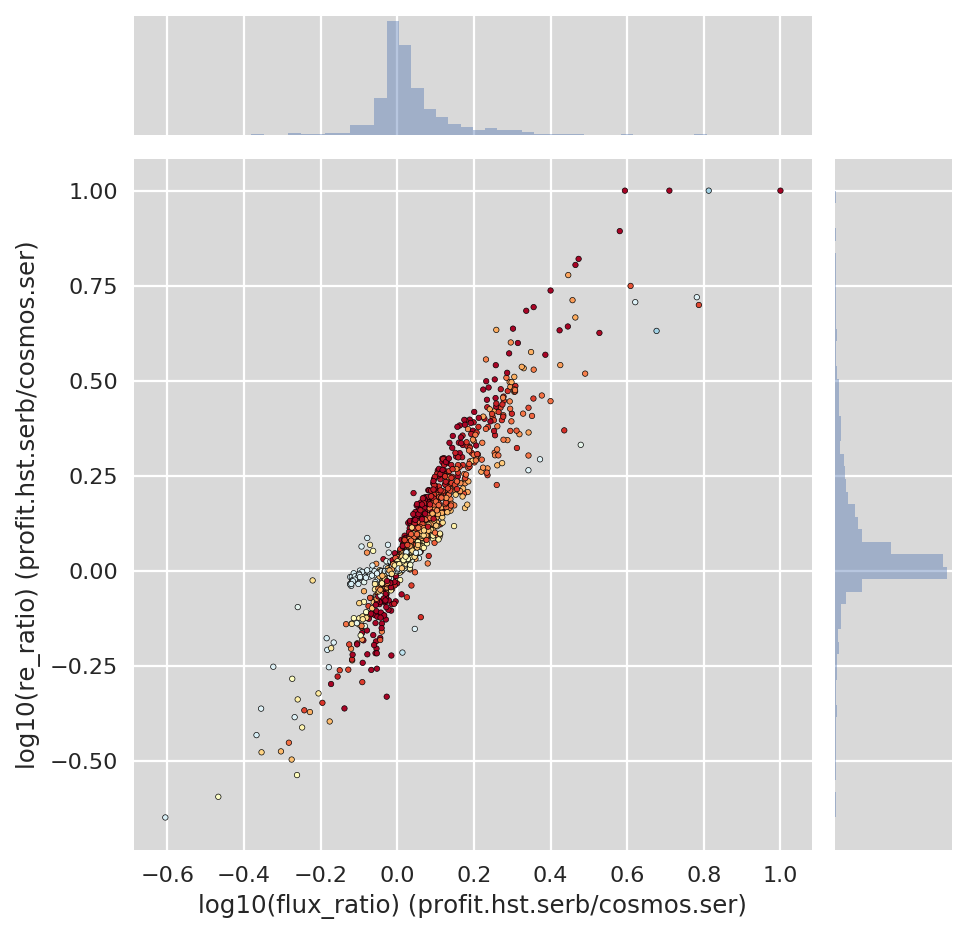

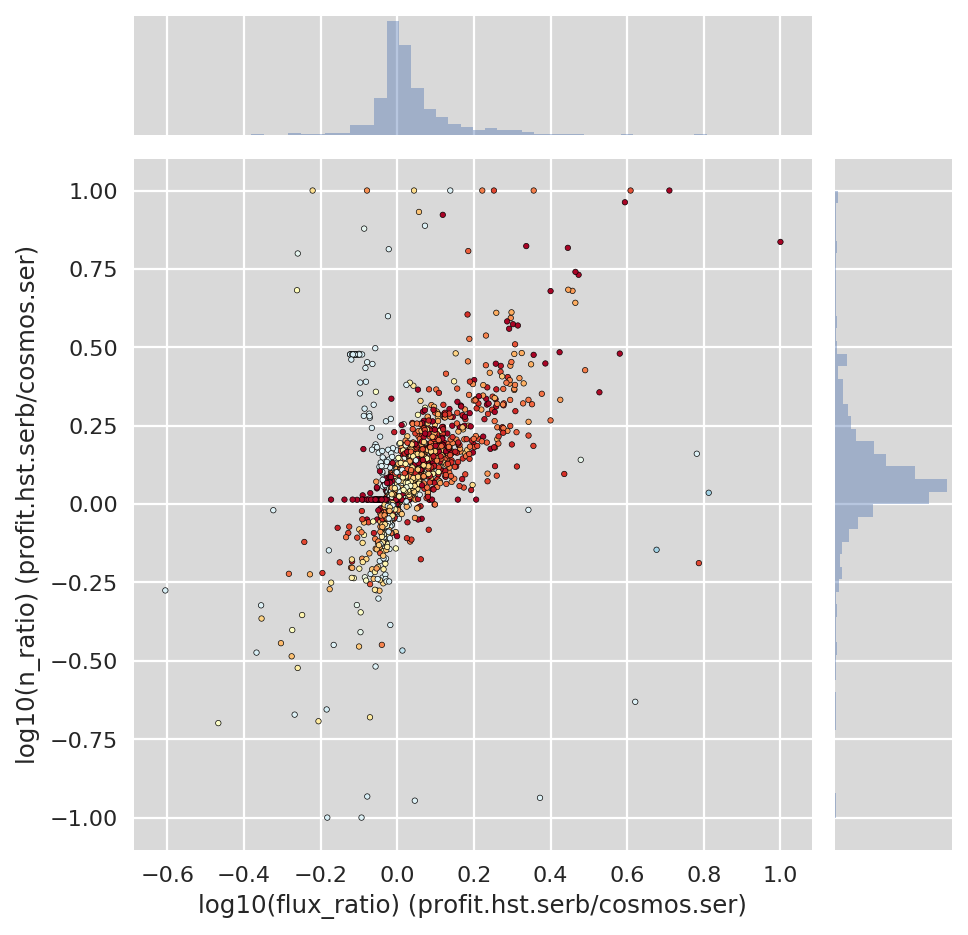

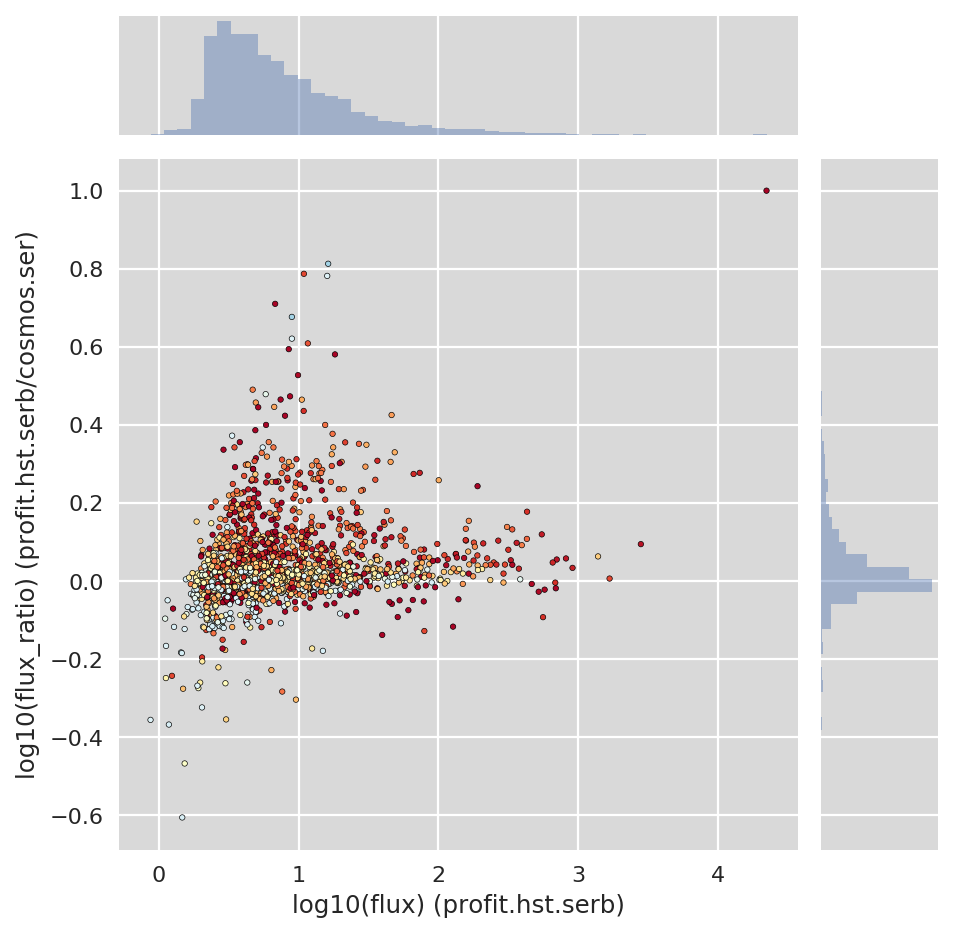

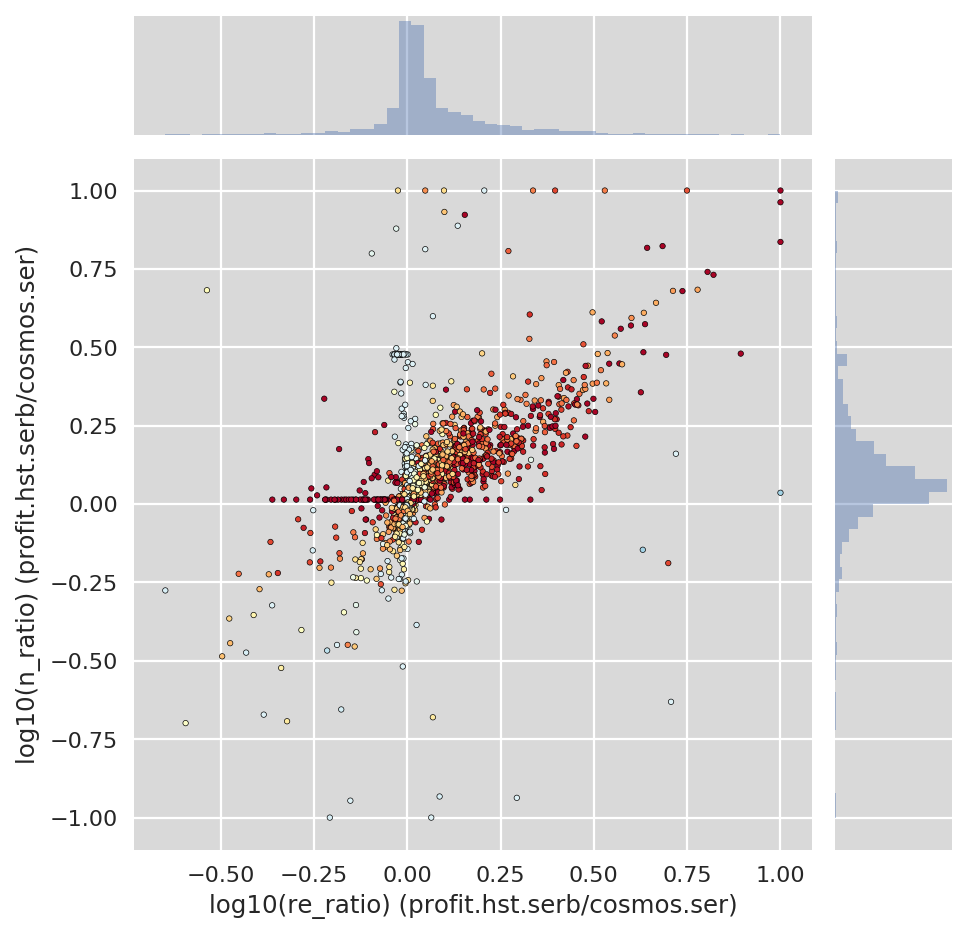

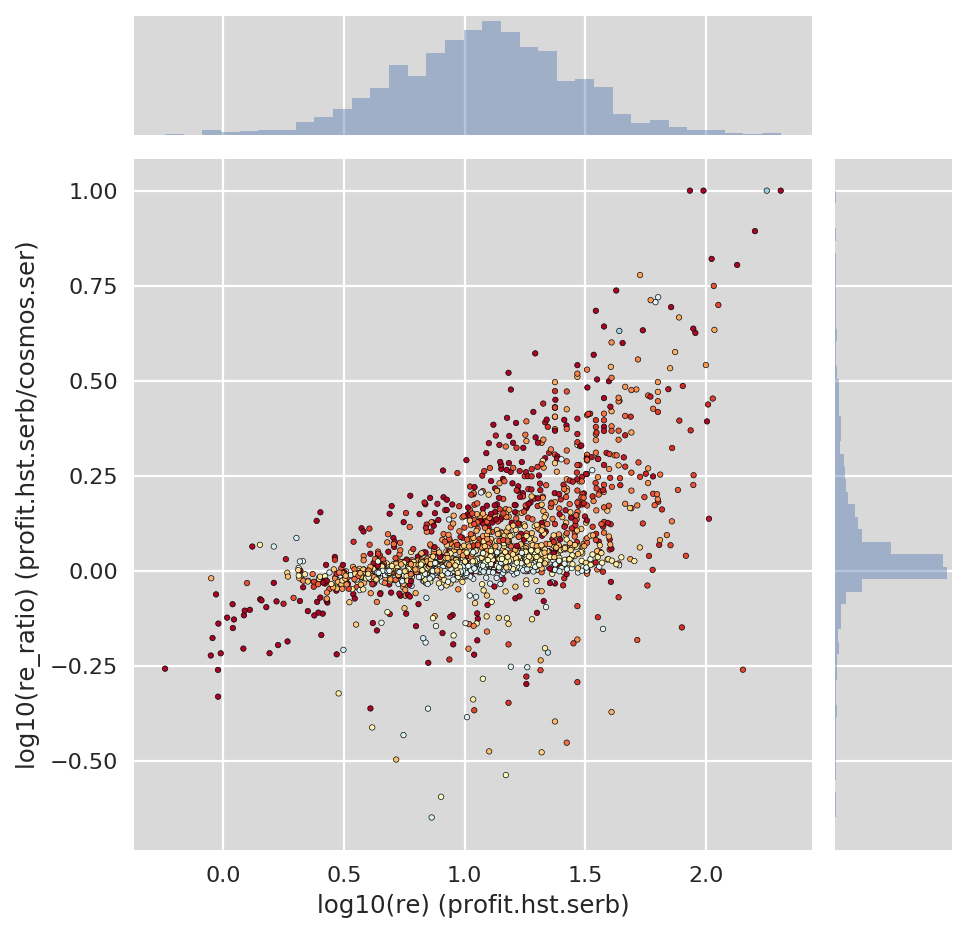

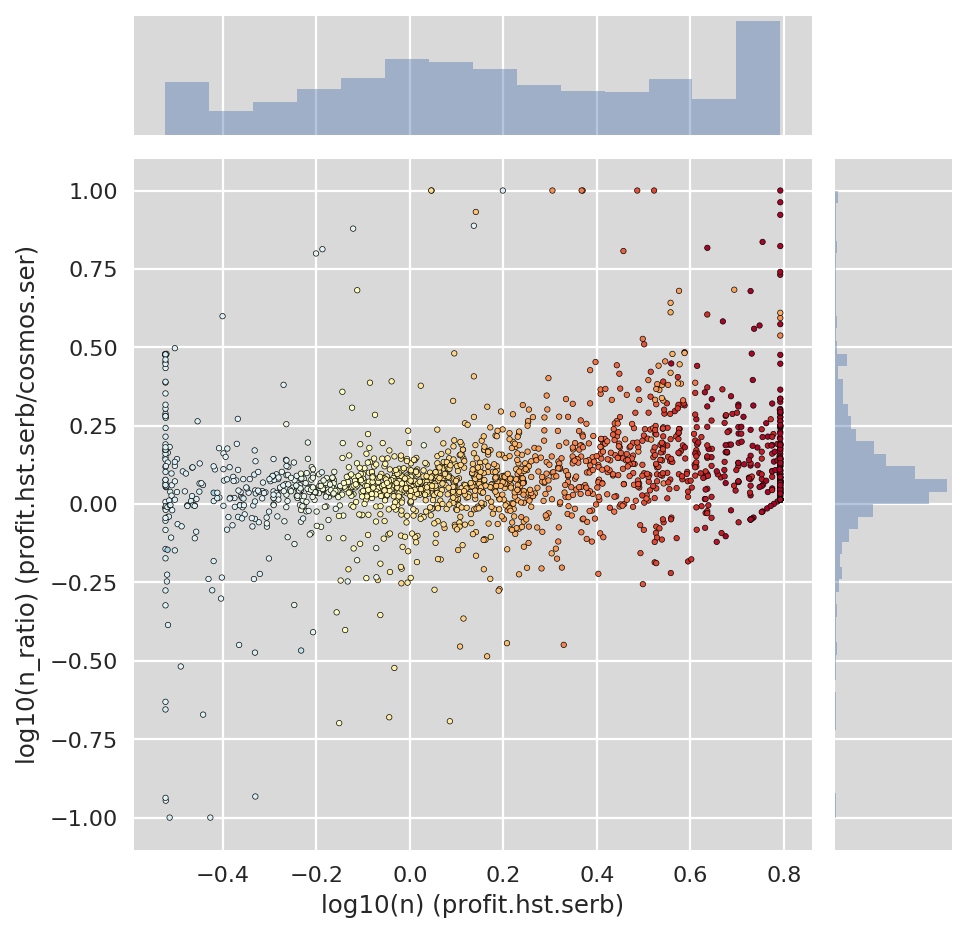

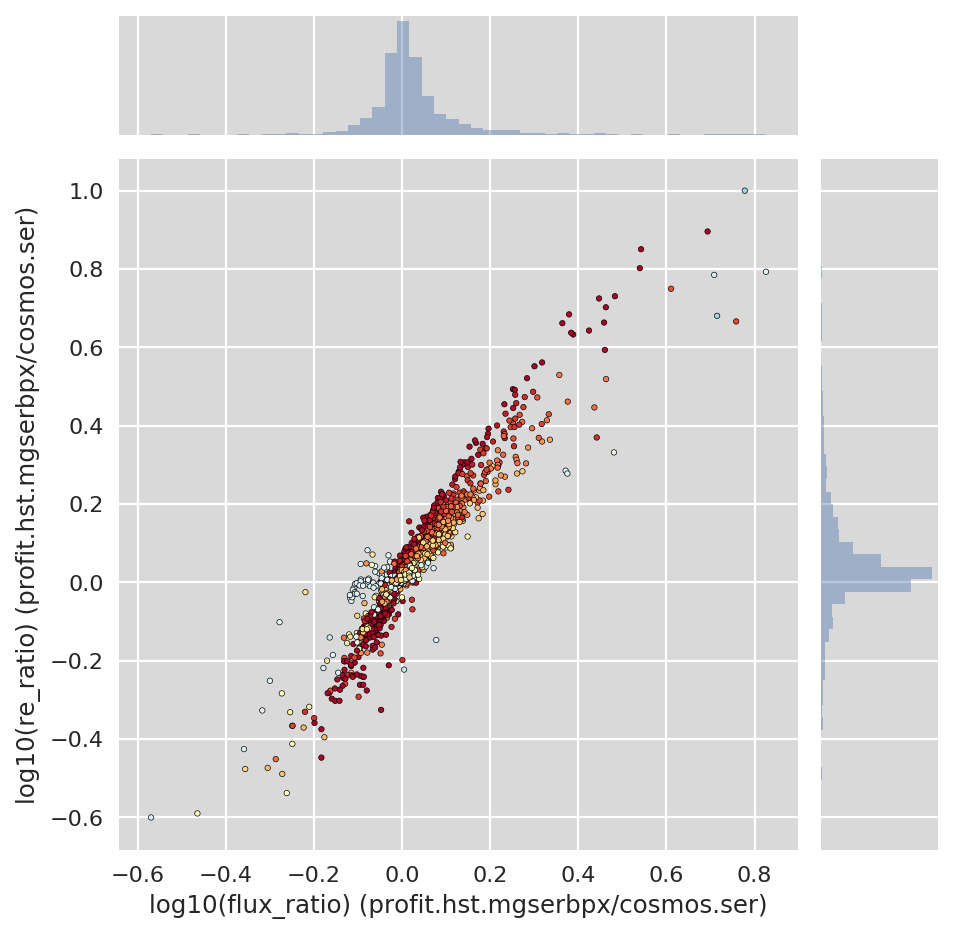

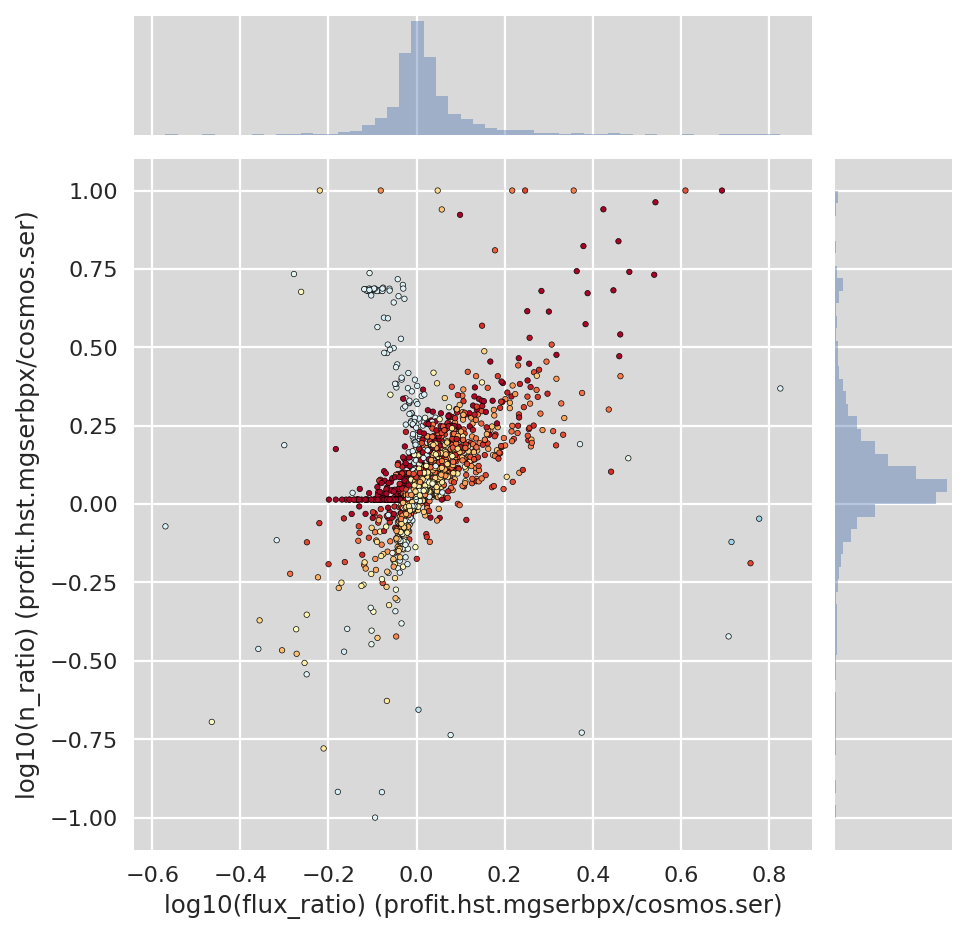

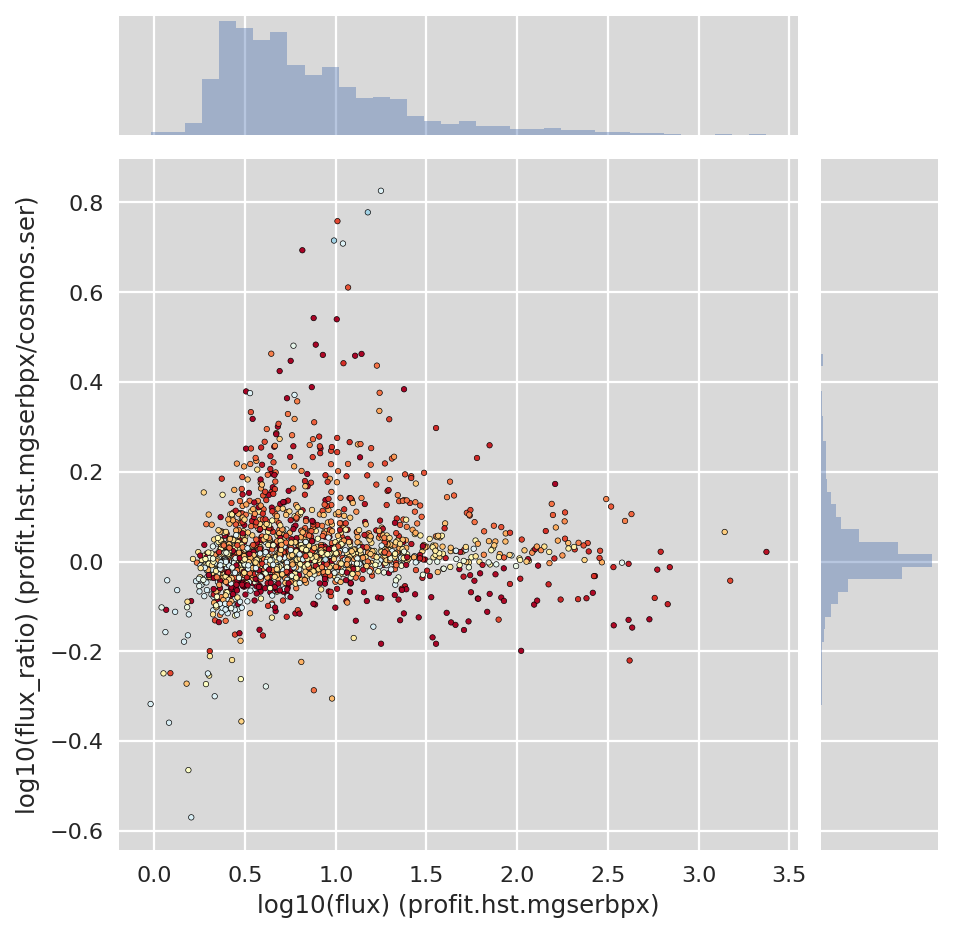

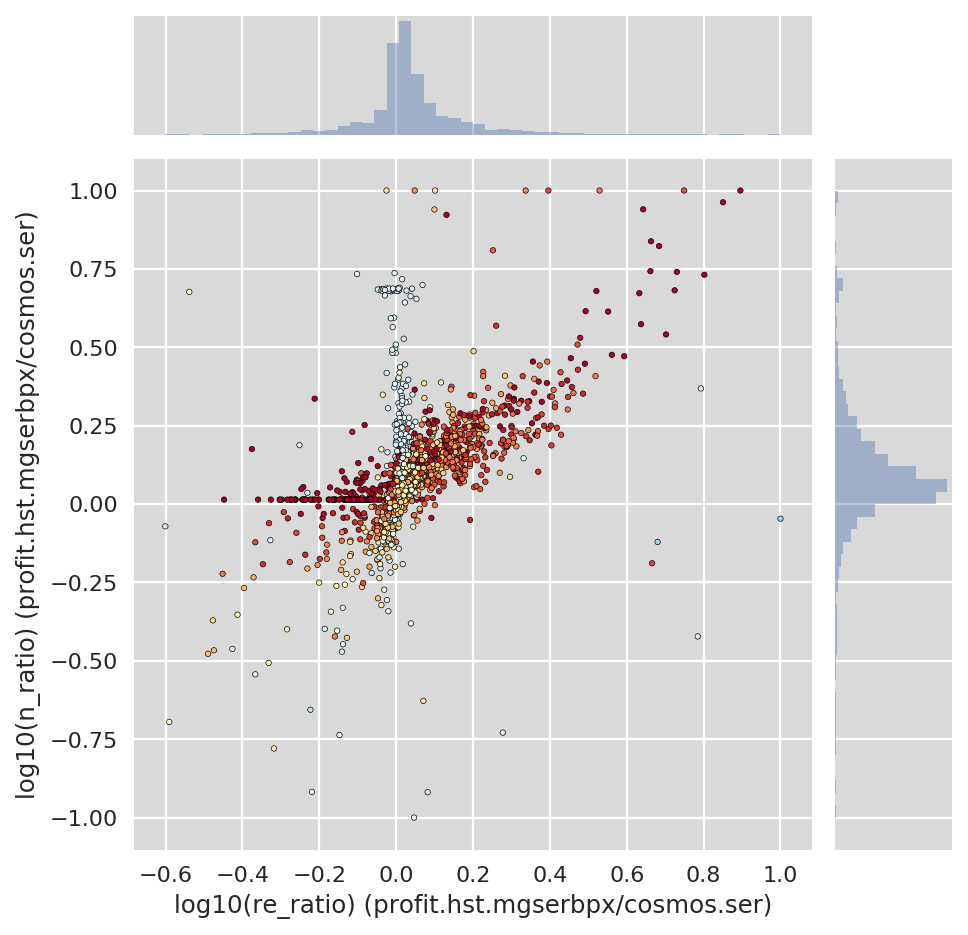

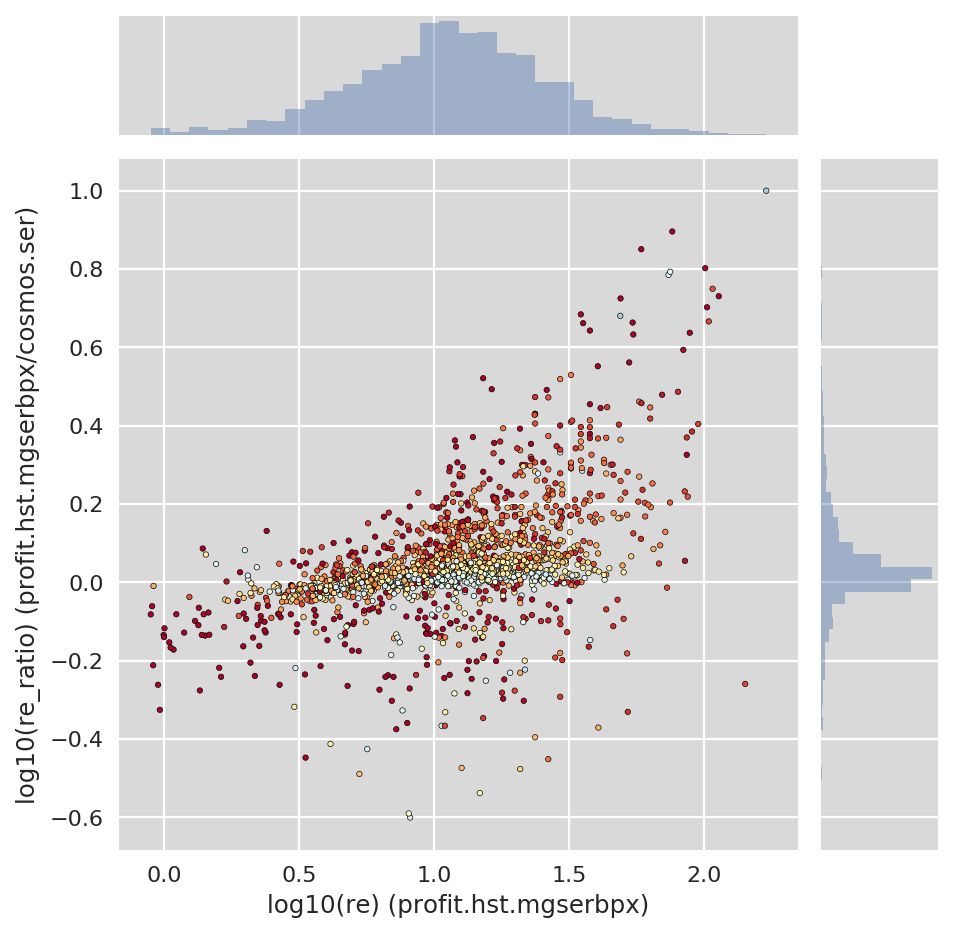

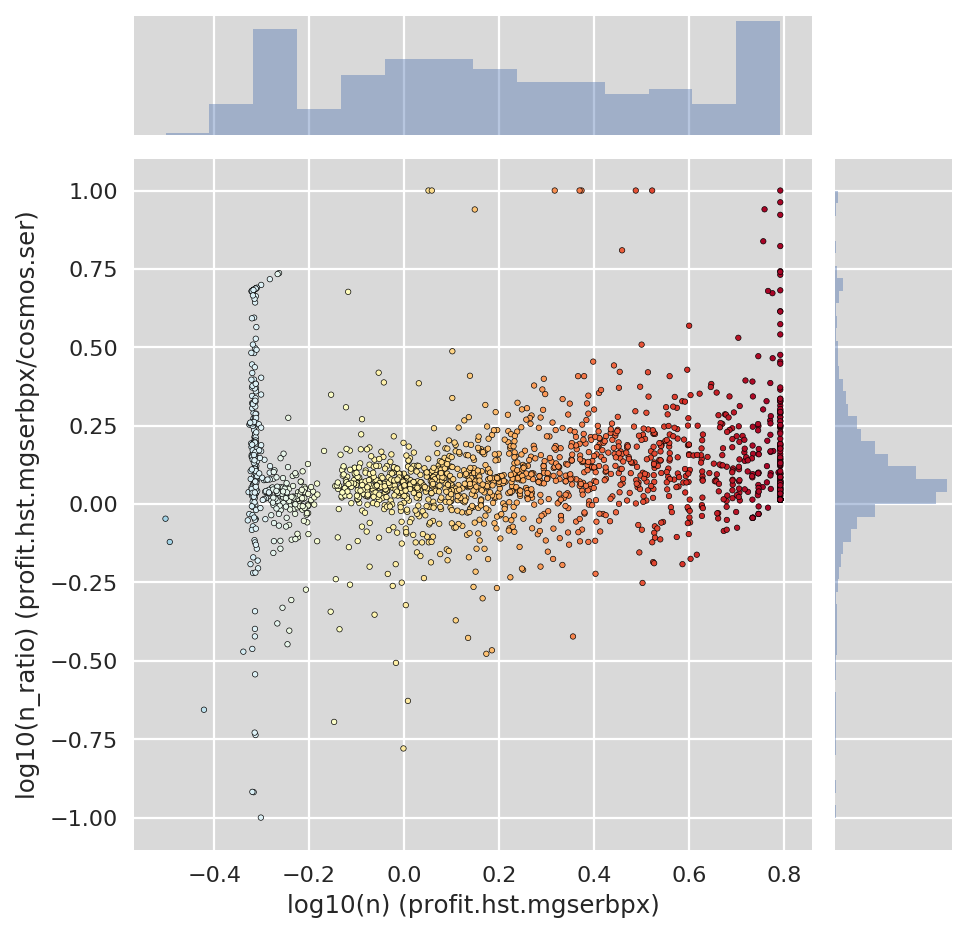

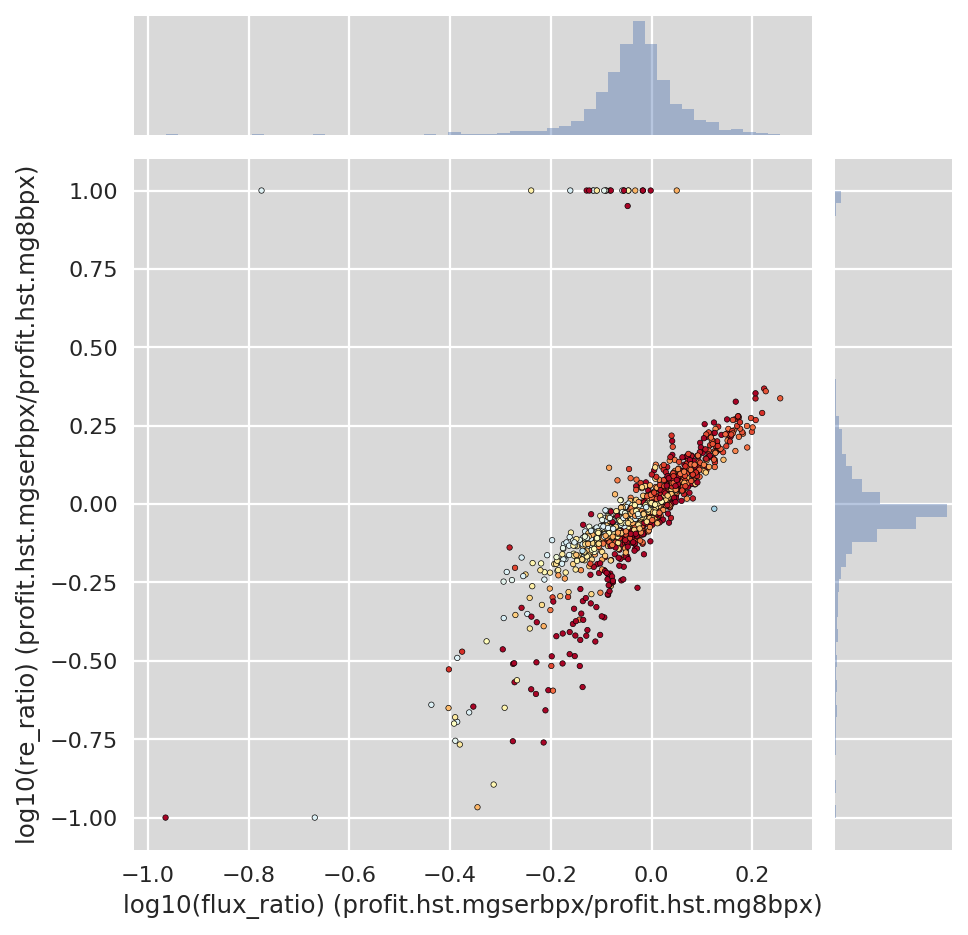

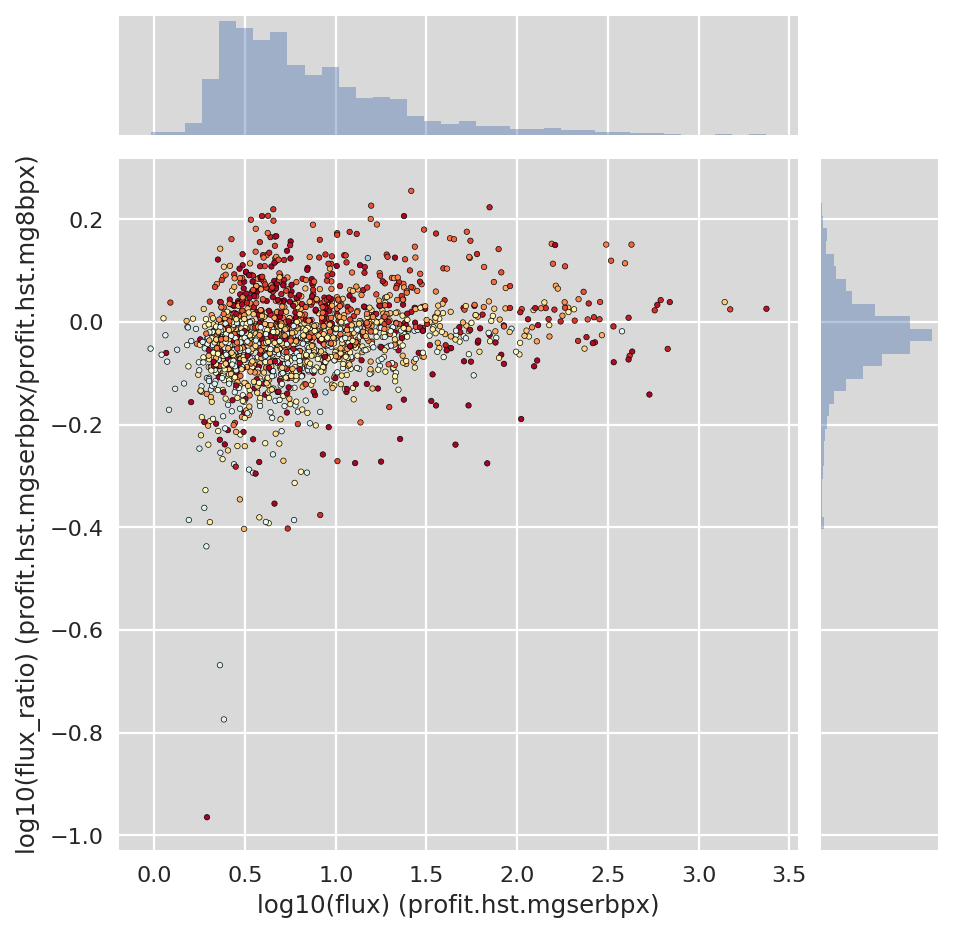

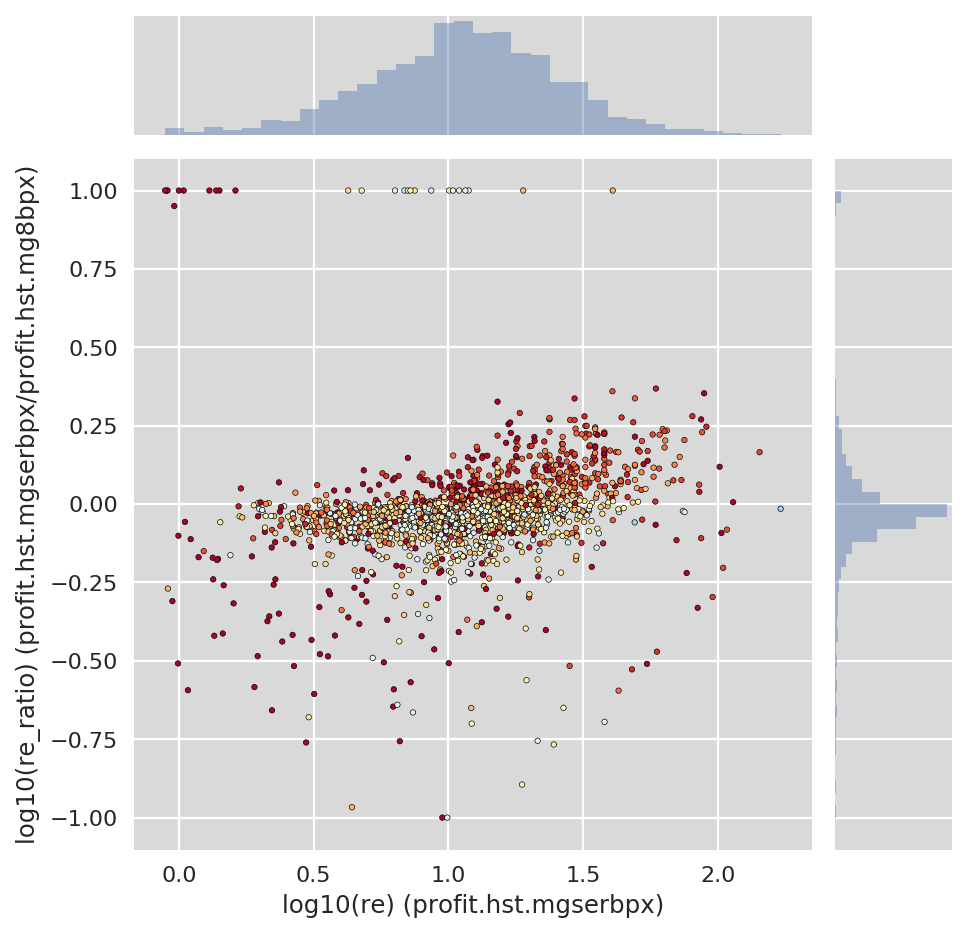

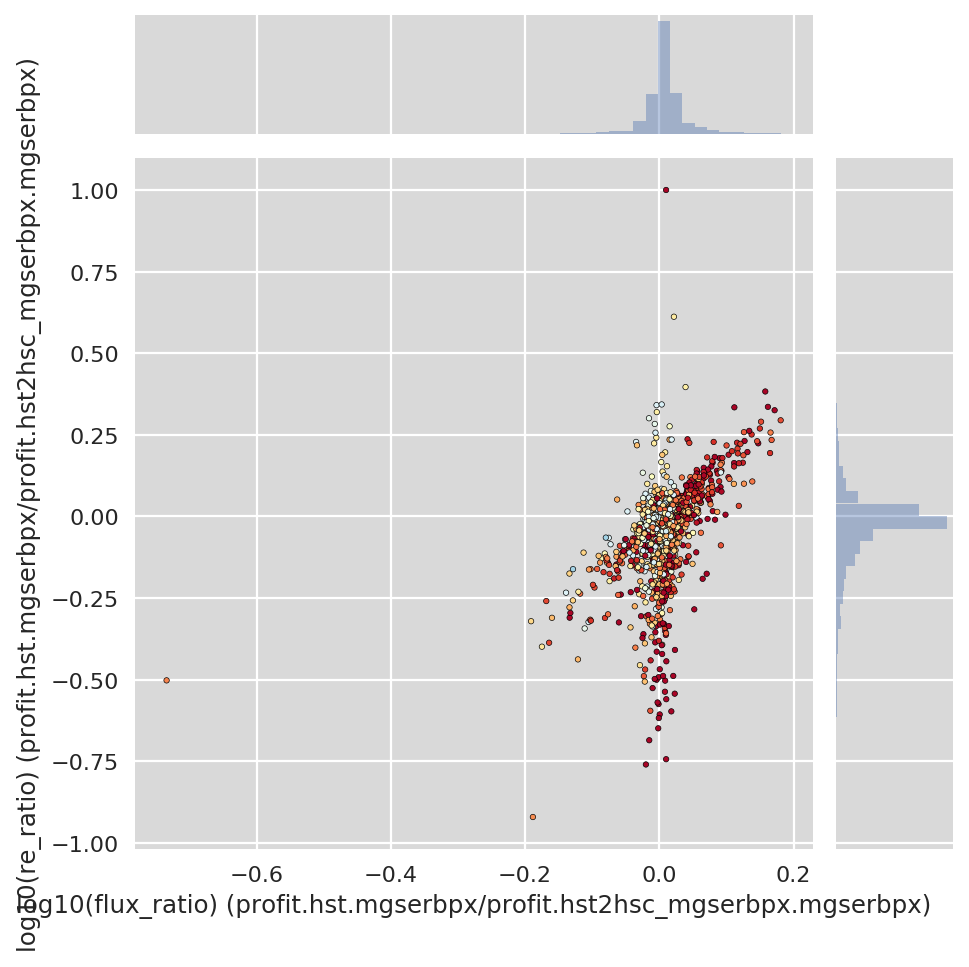

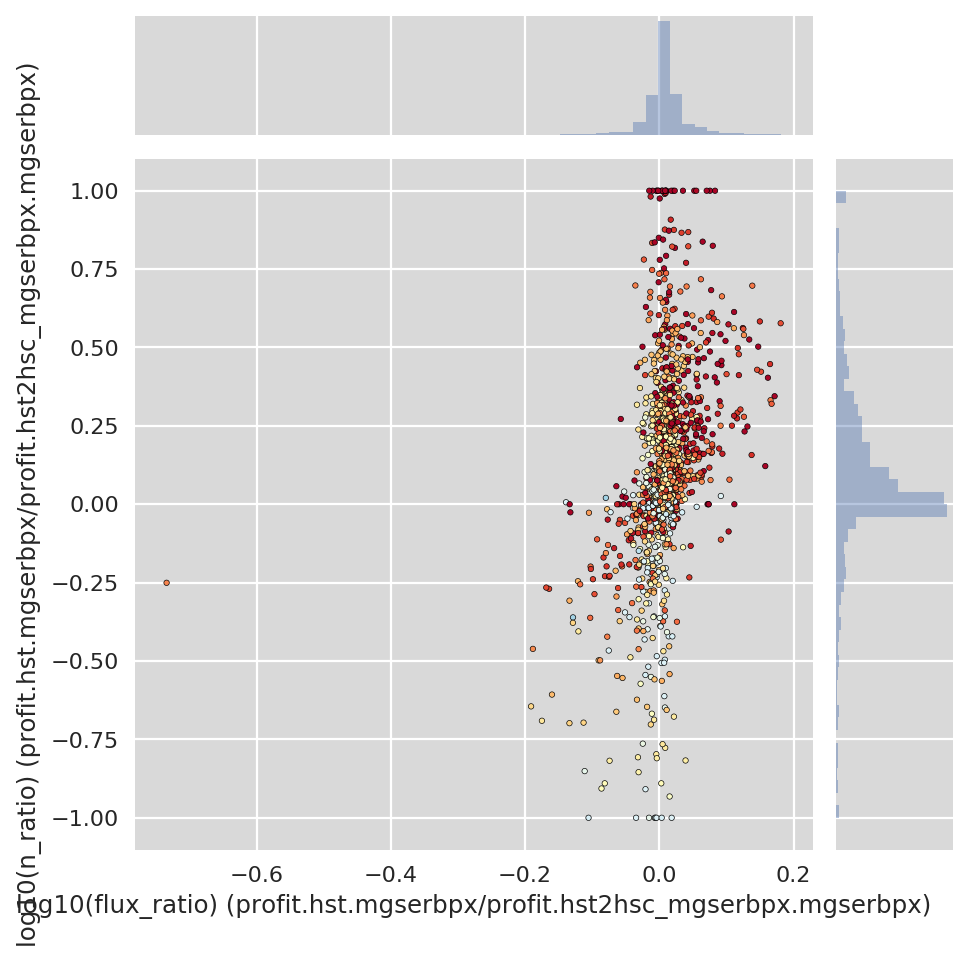

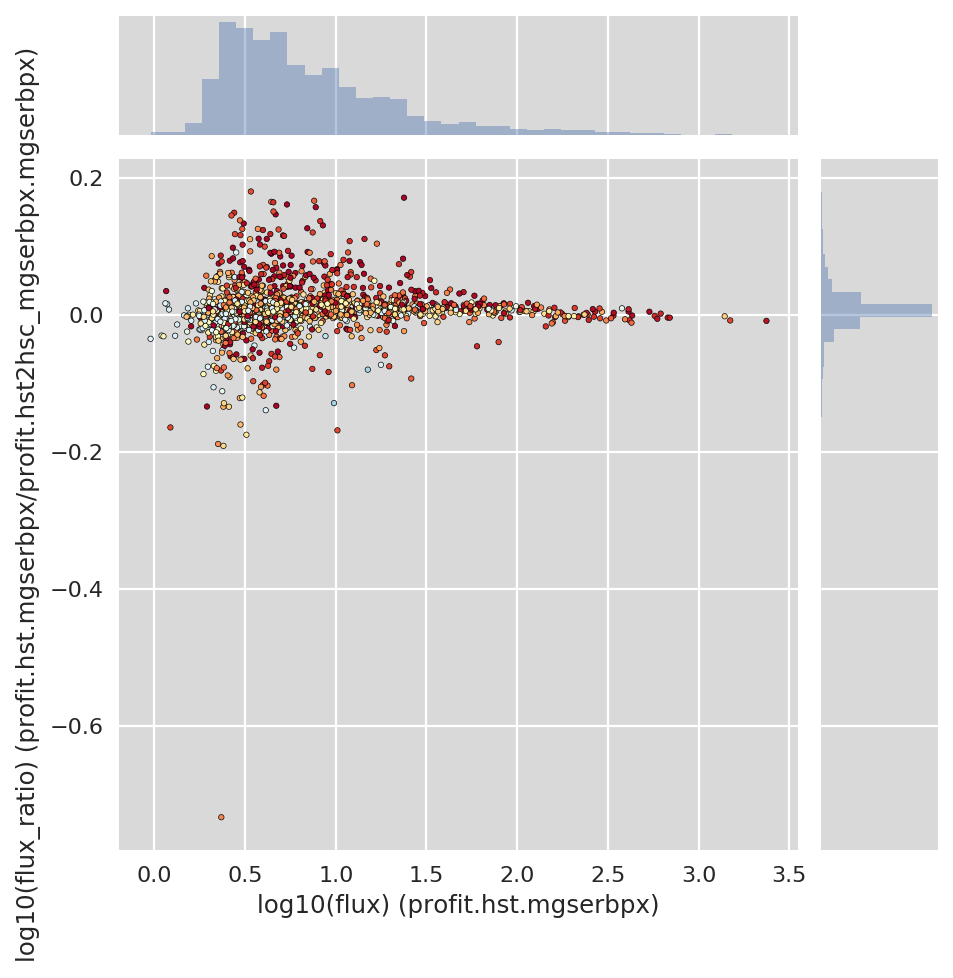

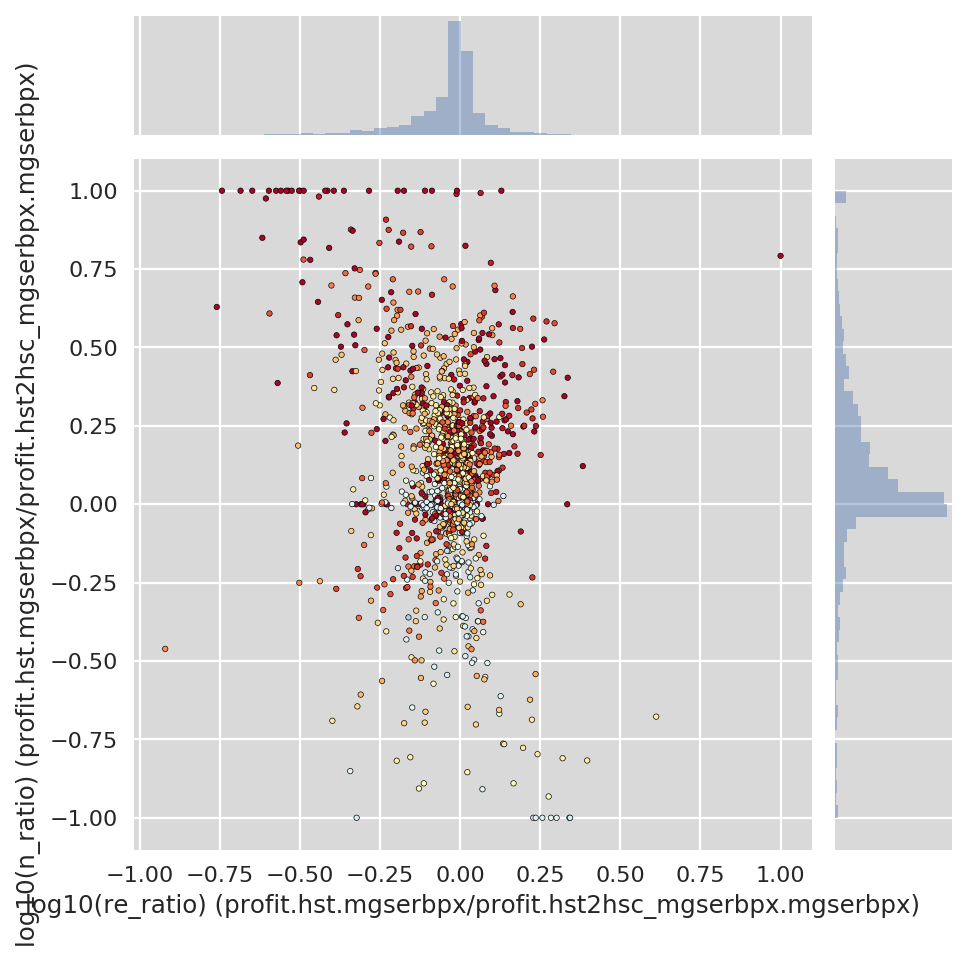

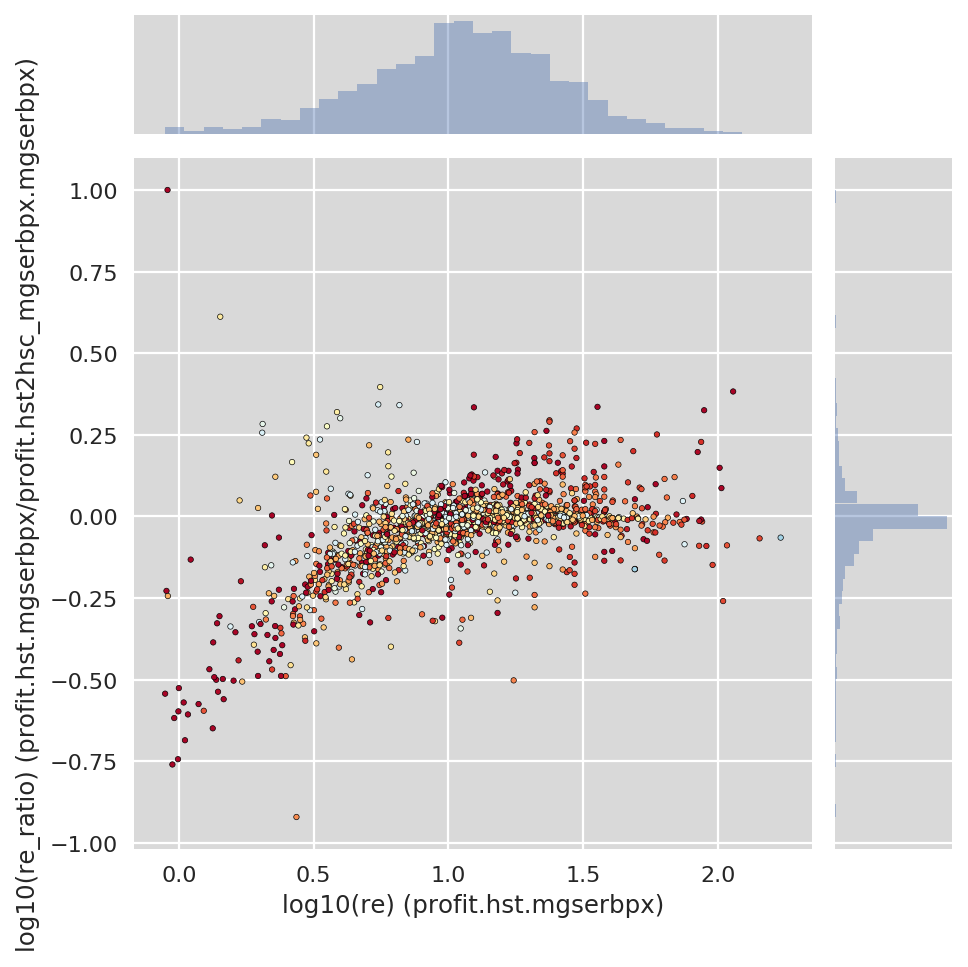

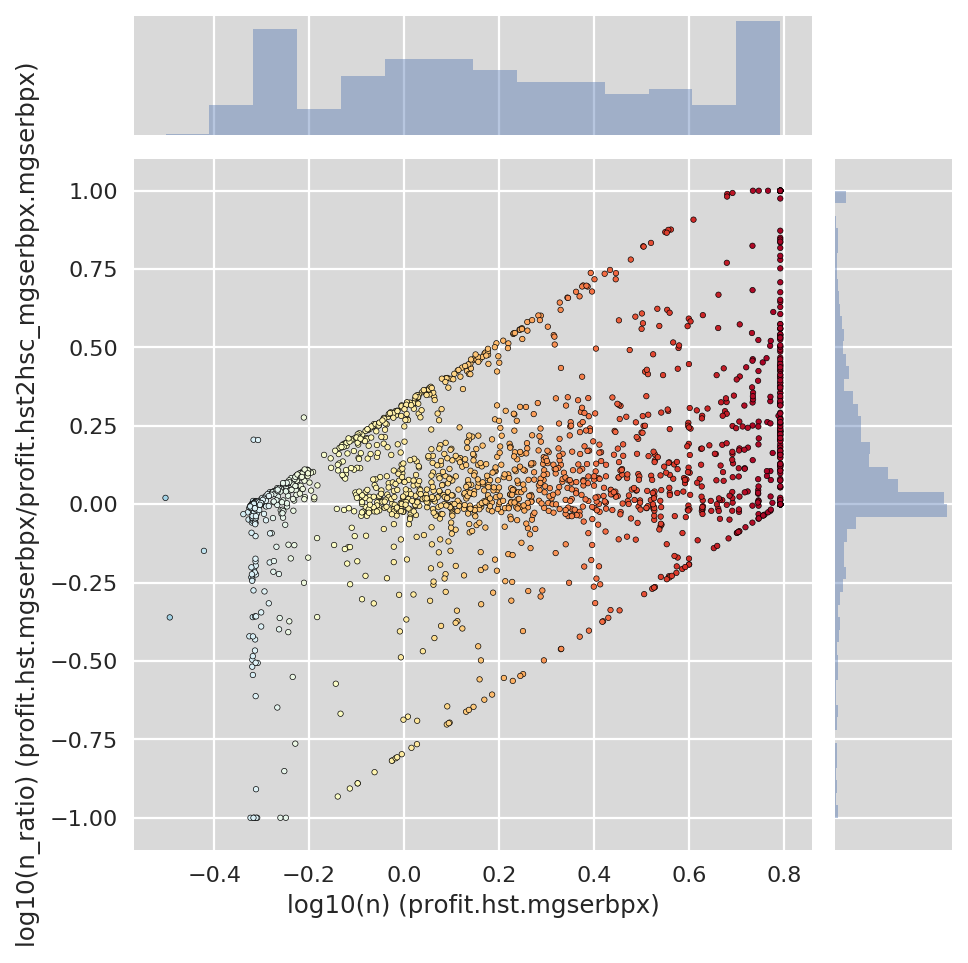

In [9]:
# How well are parameters recovered?
# First check consistency with previous fits (Sersic only for now)
# Then HSC vs HST


varnames = ["flux", "re", "n"]
prefixes = [
    ("profit.hst.serb", "cosmos.ser", varnames),
    ("profit.hst.mgserbpx", "cosmos.ser", varnames),
    ("profit.hst.mgserbpx", "profit.hst.mg8bpx", ["flux", "re"]),
    ("profit.hst.mgserbpx", "profit.hst2hsc_mgserbpx.mgserbpx", 
     varnames),
#    ("profit.hst.ser", "profit.hst2hsc_devexp.ser", vars),
#    ("profit.hst.ser", "profit.hst2hsc.ser", vars)
]

cmap = mpl.colors.ListedColormap(sns.color_palette("RdYlBu_r", 100))
colors = (np.log10(tab["profit.hst.mgserbpx.n"])+1)/np.log10(60)
colors = cmap(np.rint(100*colors)/100)


def getname(var, prefix):
    return ".".join([prefix, var])


for prefixx, prefixy, varnames in prefixes:
    ratios = {var: tab[getname(var, prefixx)]/tab[getname(var, prefixy)] for 
              var in varnames}
    for i, x in enumerate(varnames): 
        xlog = np.log10(ratios[x])
        xlog[xlog > 1] = 1
        xlog[xlog < -1] = -1
        for y in varnames[(i+1):(len(varnames)+1)]:
            namey = getname(y, prefixy)
            ylog = np.log10(ratios[y])
            ylog[ylog > 1] = 1
            ylog[ylog < -1] = -1
            fig = sns.JointGrid(x=xlog, y=ylog)
            fig.plot_joint(plt.scatter, c=colors, marker='.',
                           edgecolor='k', s=24).set_axis_labels(
                'log10({}_ratio) ({}/{})'.format(x, prefixx, prefixy),
                'log10({}_ratio) ({}/{})'.format(y, prefixx, prefixy))
            fig.plot_marginals(sns.distplot, kde=False, hist_kws={'log': False})

        ylog = np.log10(tab[getname(x, prefixx)])
        fig = sns.JointGrid(x=ylog, y=xlog)
        fig.plot_joint(plt.scatter, c=colors, marker='.',
                       edgecolor='k', s=24).set_axis_labels(
            'log10({}) ({})'.format(x, prefixx),
            'log10({}_ratio) ({}/{})'.format(x, prefixx, prefixy))
        fig.plot_marginals(sns.distplot, kde=False, hist_kws={'log': False})
        #cax = fig.add_axes([.94, .25, .02, .6])

### Model comparison plots

These plots compare the goodness of fit (reduced chi-squared in this case) of different model combinations. This mainly helps to determine which models are worth fitting and - judging by the absolute goodness of fit and the best-fit Sersic index for the single MG Sersic - what kind of galaxies each model is good for.

The first plot is probably the most interesting, as it shows that a single Sersic fit is better for most galaxies with a best-fit Sersic index n~0.5 or n~6 than a more complicated DevExp model, whereas the devExp model appears to do better for more typical galaxies with intermediate values of 1 < n < 4. We also see that most of the galaxies for which a low-n single Sersic fit is preferred (light blue dots below 0 on the y-axis) tend to have relatively low reduced chi-squared values; these galaxies are probably not very well resolved and the fact that the devExp fit is usually not much worse suggests that they're most likely not truly Gaussian-like profiles. On the other hand, there are a significant number of galaxies preferring high-n Sersic fits to devExp; it's possible that some of these really are extended elliptical galaxies rather than bulge+disk systems.

Some of the later plots compare equivalent models where the only differences are the initial parameters; an ideal optimizer should reach identical solutions for both.

{'gausspx': 'profit.hst.gausspx.chisqred.0', 'mgexppx': 'profit.hst.mgexppx.chisqred.0', 'mgn2px': 'profit.hst.mgn2px.chisqred.0', 'mgdev2px': 'profit.hst.mgdev2px.chisqred.0', 'mgserbpx': 'profit.hst.mgserbpx.chisqred.0', 'mgserbedpx': 'profit.hst.mgserbedpx.chisqred.0', 'mgcmodelpx': 'profit.hst.mgcmodelpx.chisqred.1', 'mgdevexppx': 'profit.hst.mgdevexppx.chisqred.1', 'mgdevexpcpx': 'profit.hst.mgdevexpcpx.chisqred.1'}
profit.hst.mgserbpx.chisqred.0       721
profit.hst.mgdevexpcpx.chisqred.1    490
profit.hst.mgdevexppx.chisqred.1     445
profit.hst.mgserbedpx.chisqred.0     157
profit.hst.gausspx.chisqred.0          3
dtype: int64
{'gausspx': 'profit.hst.gausspx.chisqred.0', 'mgexppx': 'profit.hst.mgexppx.chisqred.0', 'mgn2px': 'profit.hst.mgn2px.chisqred.0', 'mgdev2px': 'profit.hst.mgdev2px.chisqred.0', 'mgserbpx': 'profit.hst.mgserbpx.chisqred.0', 'mgserbedpx': 'profit.hst.mgserbedpx.chisqred.0', 'serbpx': 'profit.hst.serbpx.chisqred.0', 'serb': 'profit.hst.serb.chisqred.0', 'mgc

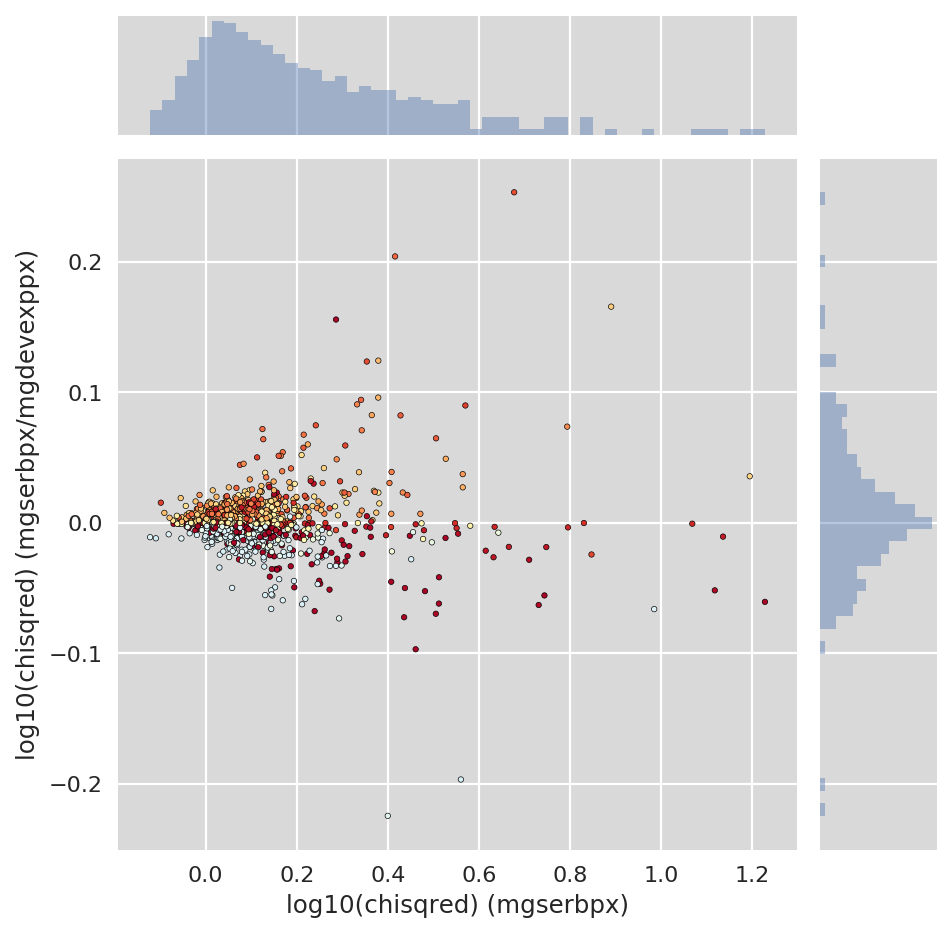

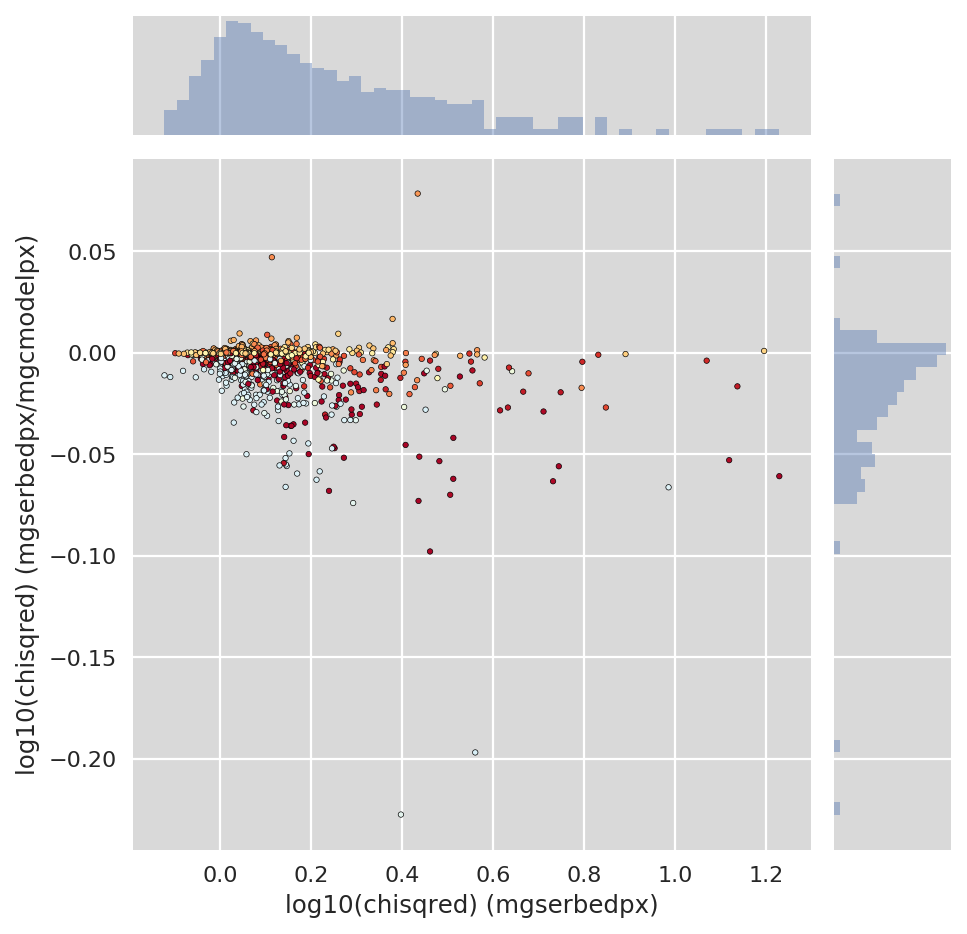

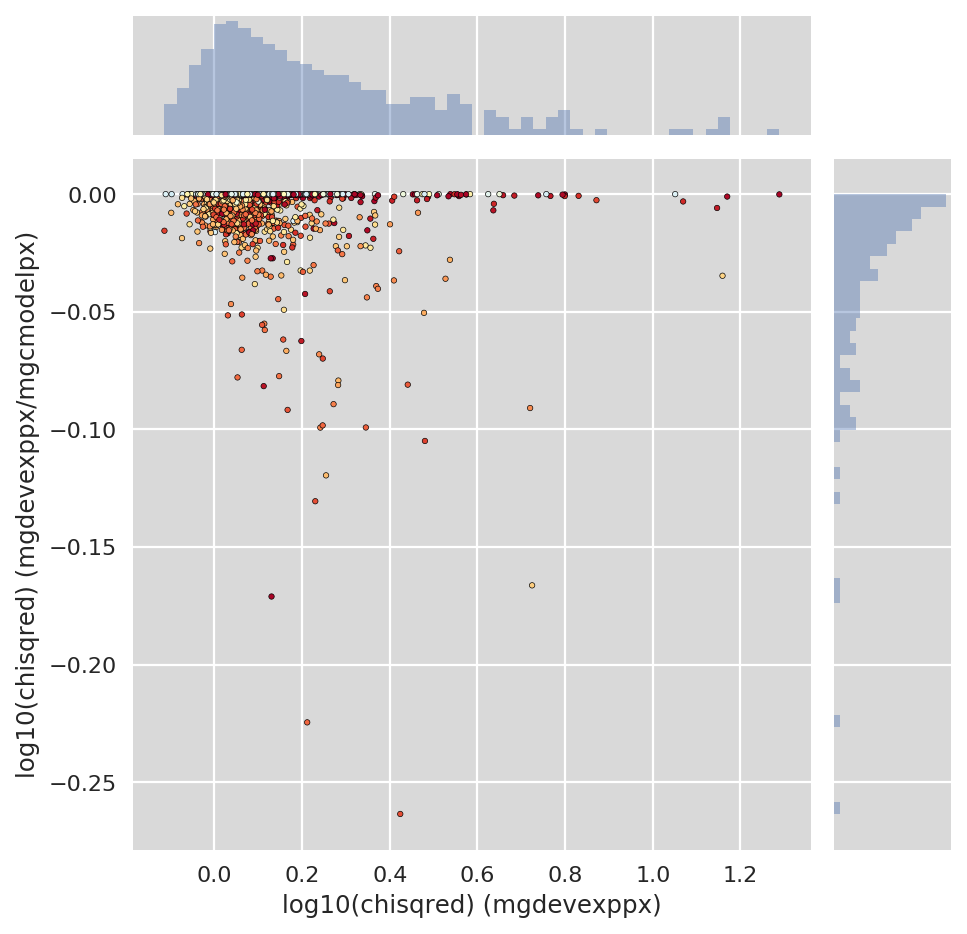

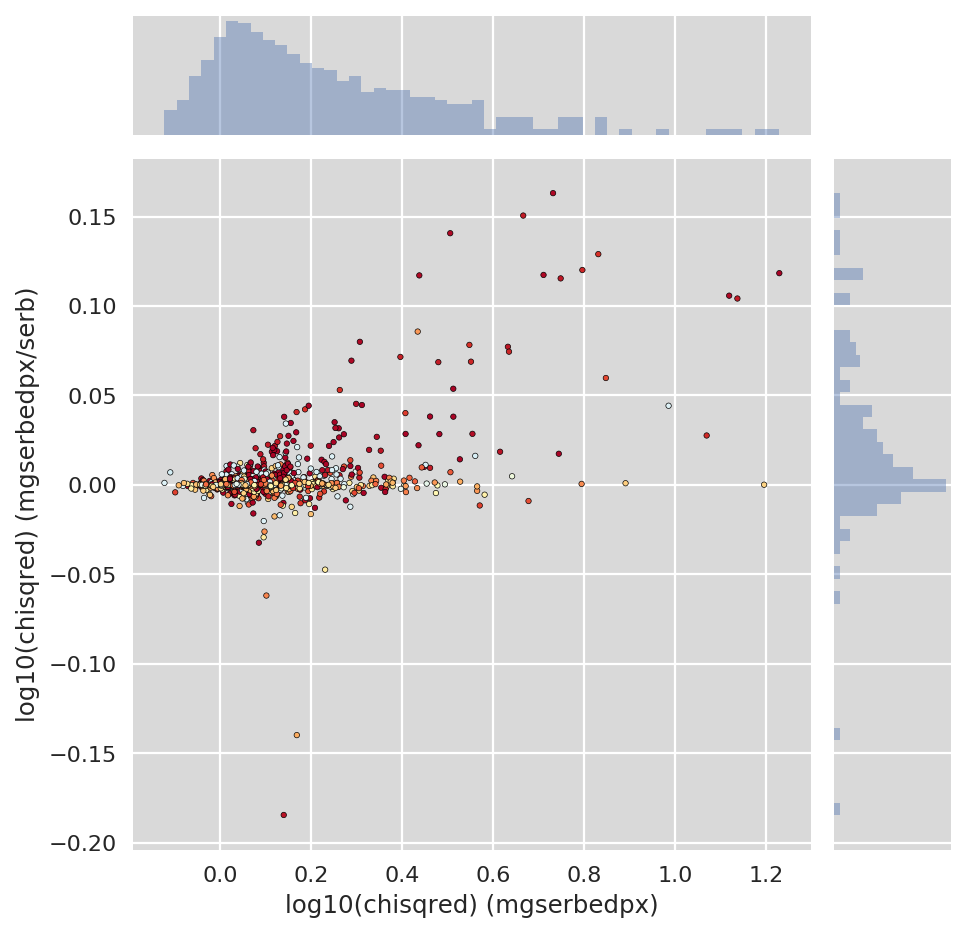

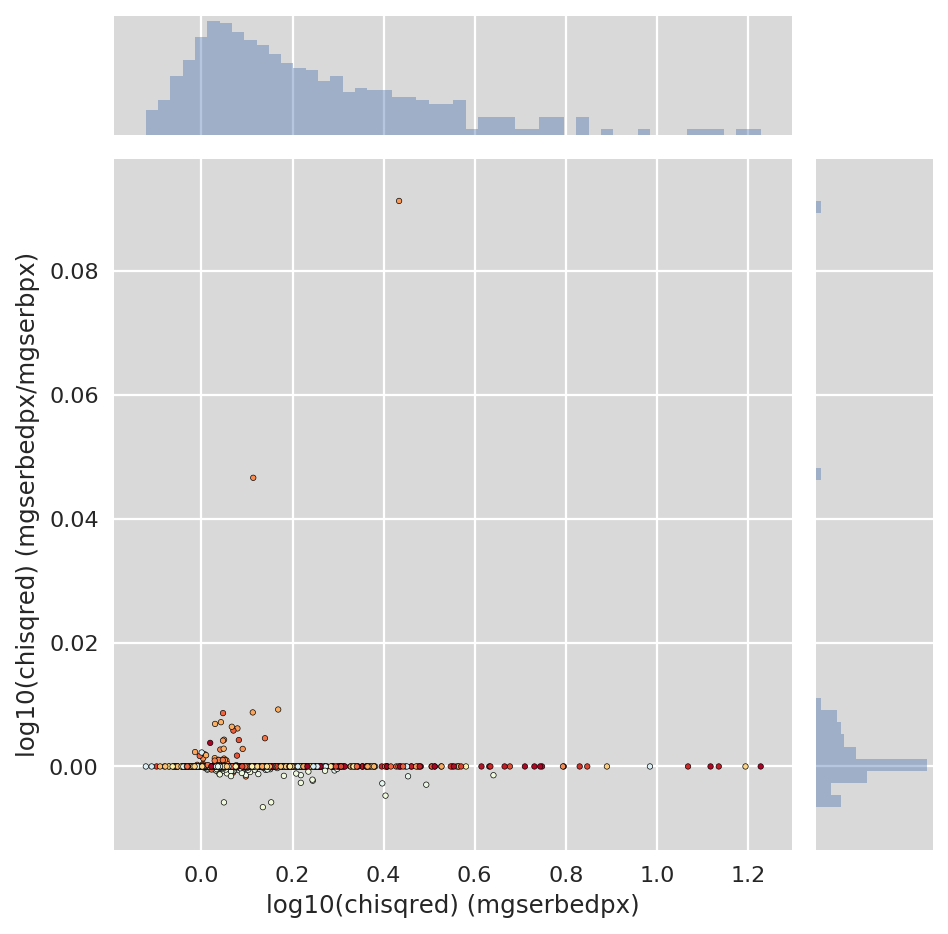

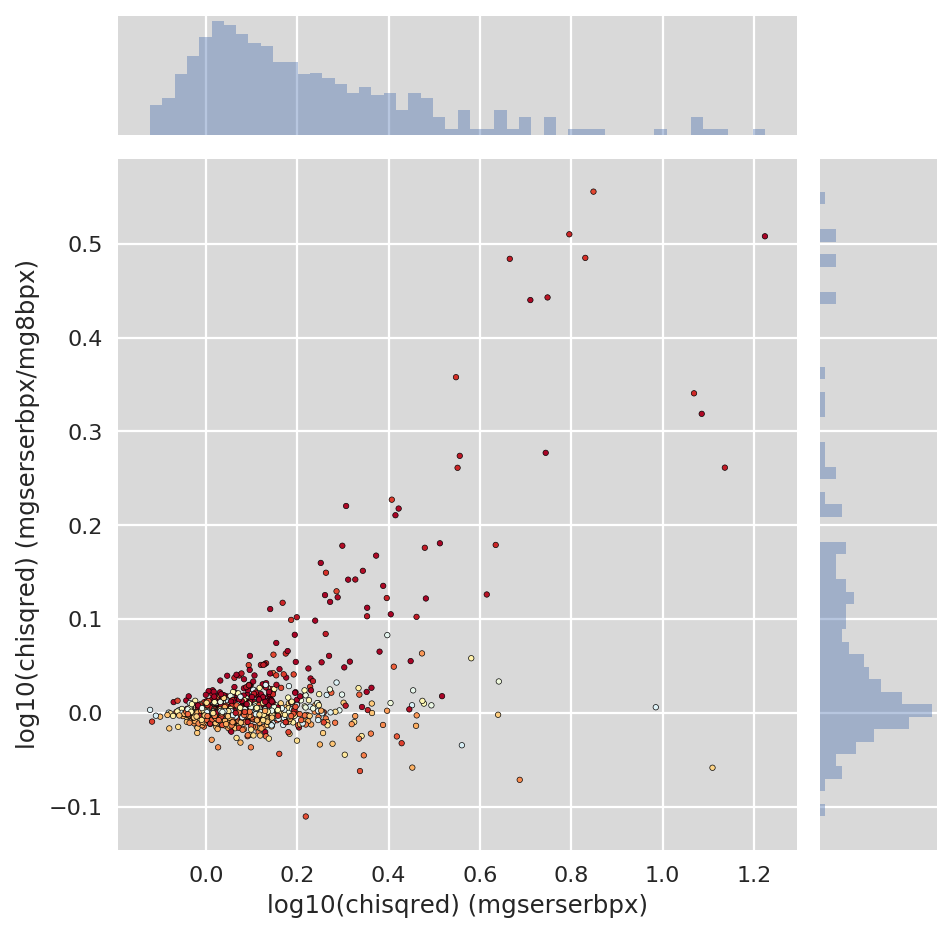

In [10]:
# Which are the best models?
modelslist = [
    [model for model in models["single"]["profit"] if not model.startswith('serb')] + [model for model in models["double"]["profit"] if model != 'mgserserbpx'],
    models["single"]["profit"] + [model for model in models["double"]["profit"] if model != 'mgserserbpx'] + models['mg8']['profit'],
    models["single"]["profit"] + models["double"]["profit"] + models['mg8']['profit'],
]
for modelsprofit in modelslist:
    chisqredcols = {
        model: ".".join(["profit", "hst", model, "chisqred",
                         "1" if model in models['double']['profit'] else "0"]) 
        for model in modelsprofit
    }
    print(chisqredcols)
    modelbest = tab[list(chisqredcols.values())].idxmin(axis=1)
    modelbestcounts = modelbest.value_counts()
    print(modelbestcounts)

# Plot direct model comparisons
for colx, coly in [("mgserbpx", "mgdevexppx"), ("mgserbedpx", "mgcmodelpx"), 
                   ("mgdevexppx", "mgcmodelpx"), ("mgserbedpx", "serb"),
                   ("mgserbedpx", "mgserbpx"), ("mgserserbpx", "mg8bpx")]:
    fig = sns.JointGrid(x=np.log10(tab[chisqredcols[colx]]),
                        y=np.log10(tab[chisqredcols[colx]]/tab[chisqredcols[coly]]))
    fig.plot_joint(plt.scatter, c=colors, marker='.',
                   edgecolor='k', s=24).set_axis_labels(
        'log10(chisqred) ({})'.format(colx),
        'log10(chisqred) ({}/{})'.format(colx, coly))
    fig.plot_marginals(sns.distplot, kde=False, hist_kws={'log': True})

### MG Sersic fixed-n vs free-n fits

These plots compare fixed- versus free-n single Sersic fits. This is to help determine an optimal workflow for fitting increasingly complicated models. For example, the Gaussian model is the fastest to evaluate, but it's also the least likely to be the best fit out of the four fixed-n models (n=0.5, 1, 2, 4).

Another plot compares the goodness of fit for the free-n versus the best-fit fixed-n model, showing that in most cases a fixed-n model is not far off - that is, there are not many galaxies where there's a very significant benefit to fitting n=1.5 or n=3 vs n=2. The exception is the galaxies that prefer n=6 to n=4.

The last plot compares the free Sersic to an exponential, showing that an exponential is 'good enough' for most galaxies except those with best-fit n>4. This suggests that the exponential model would be a reasonable choice if we had to pick just one, which is in line with expectations that most of the galaxies in any given deep field are disky.

profit.hst.mgexppx.chisqred.0     516
profit.hst.mgdev2px.chisqred.0    509
profit.hst.mgn2px.chisqred.0      419
profit.hst.gausspx.chisqred.0     372
dtype: int64


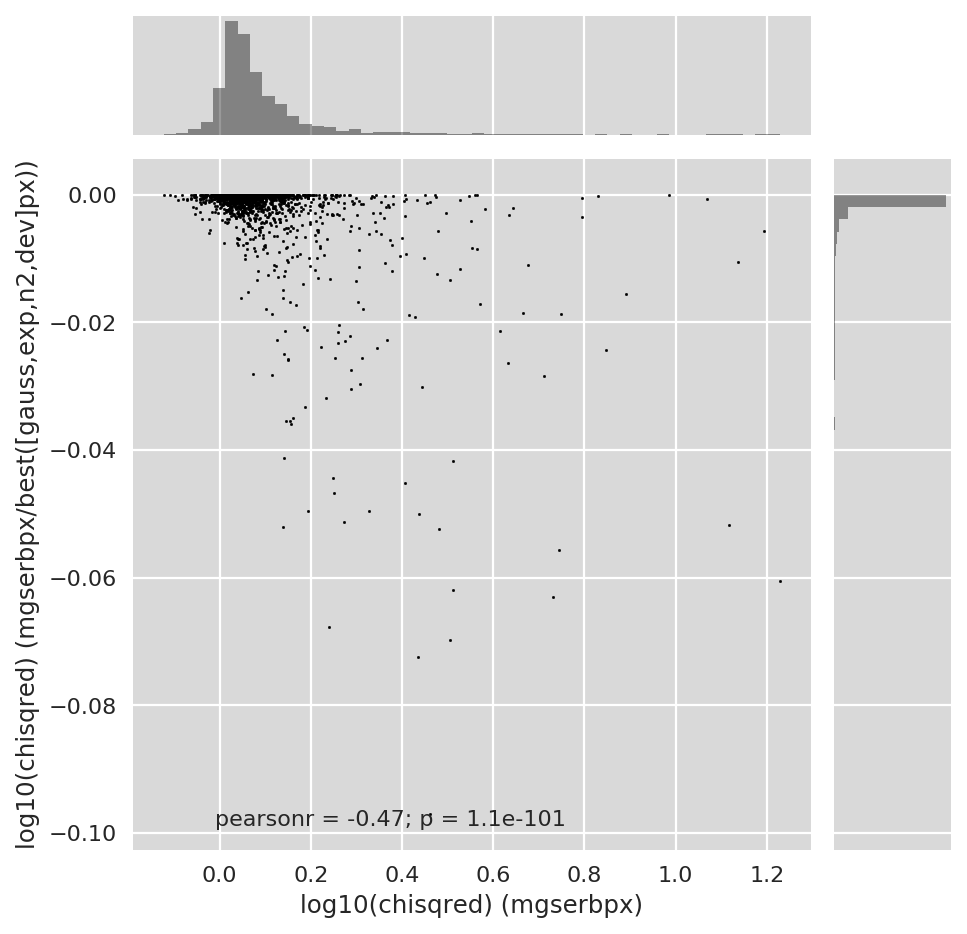

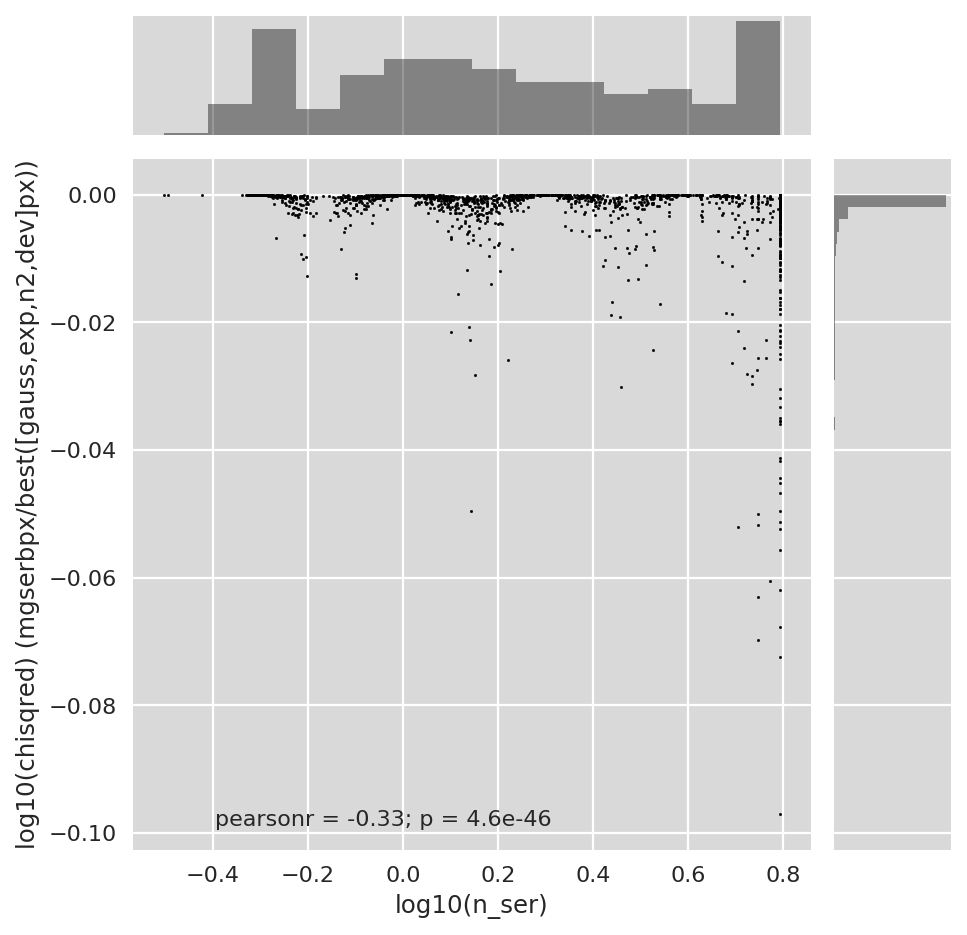

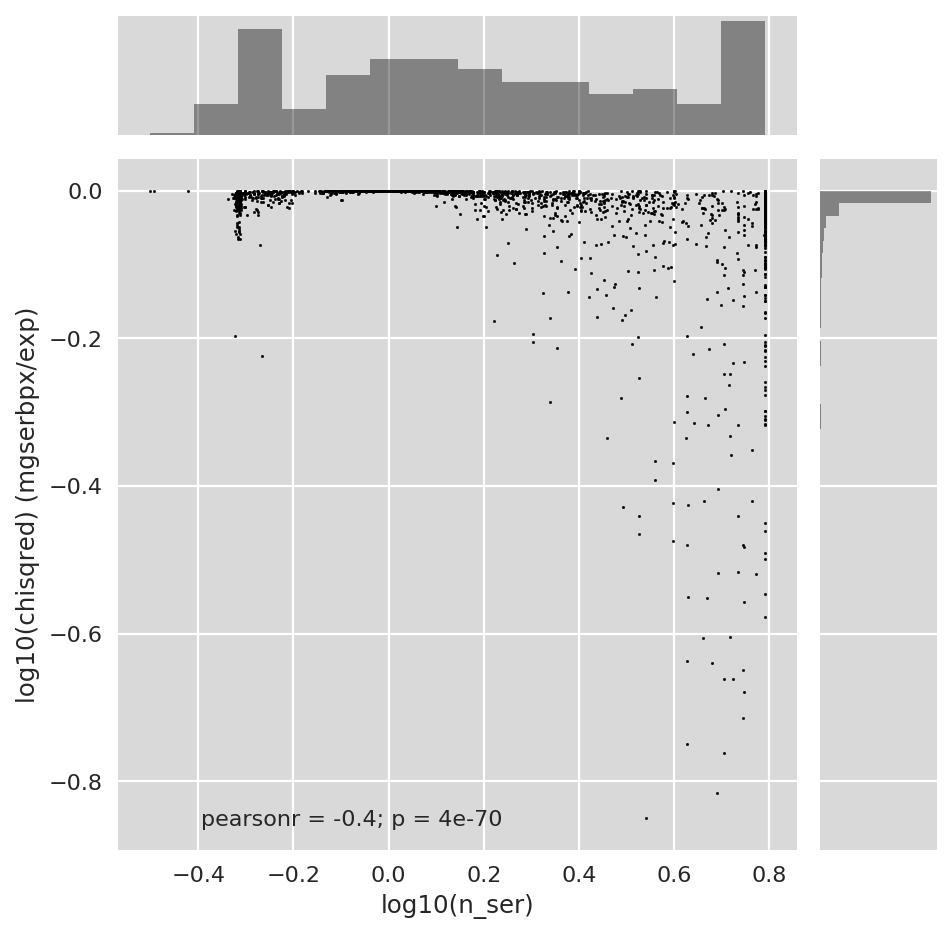

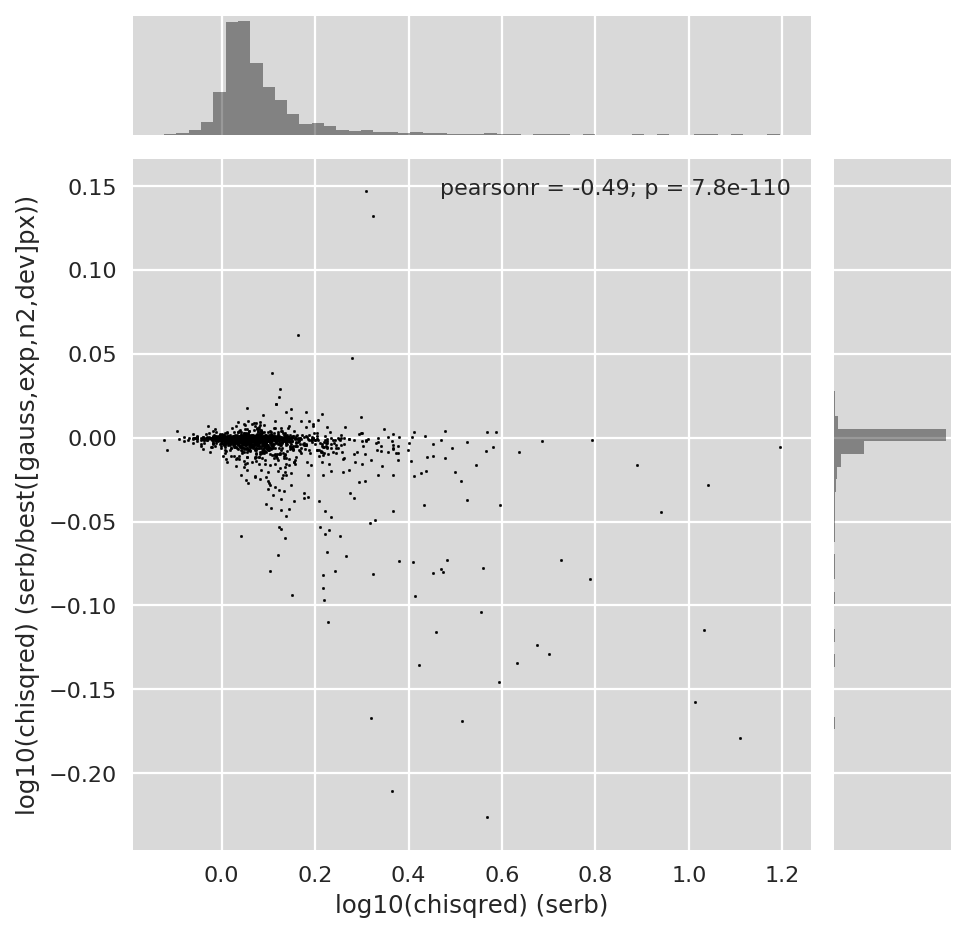

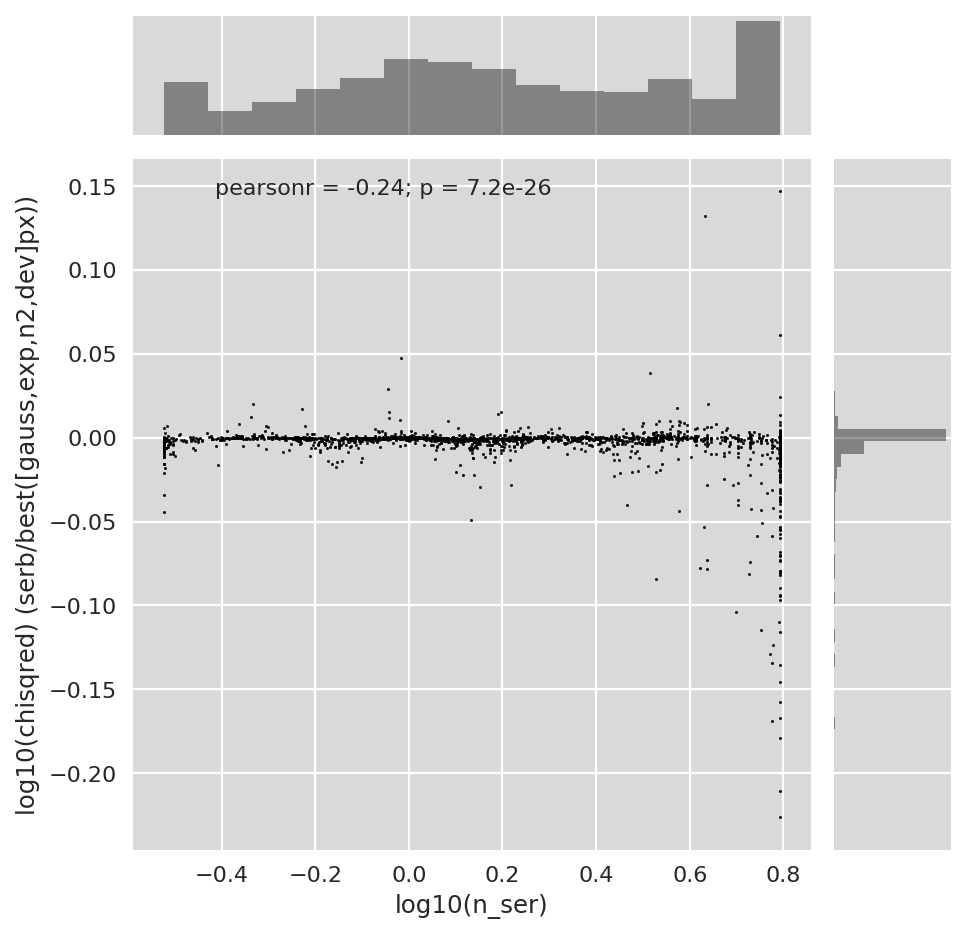

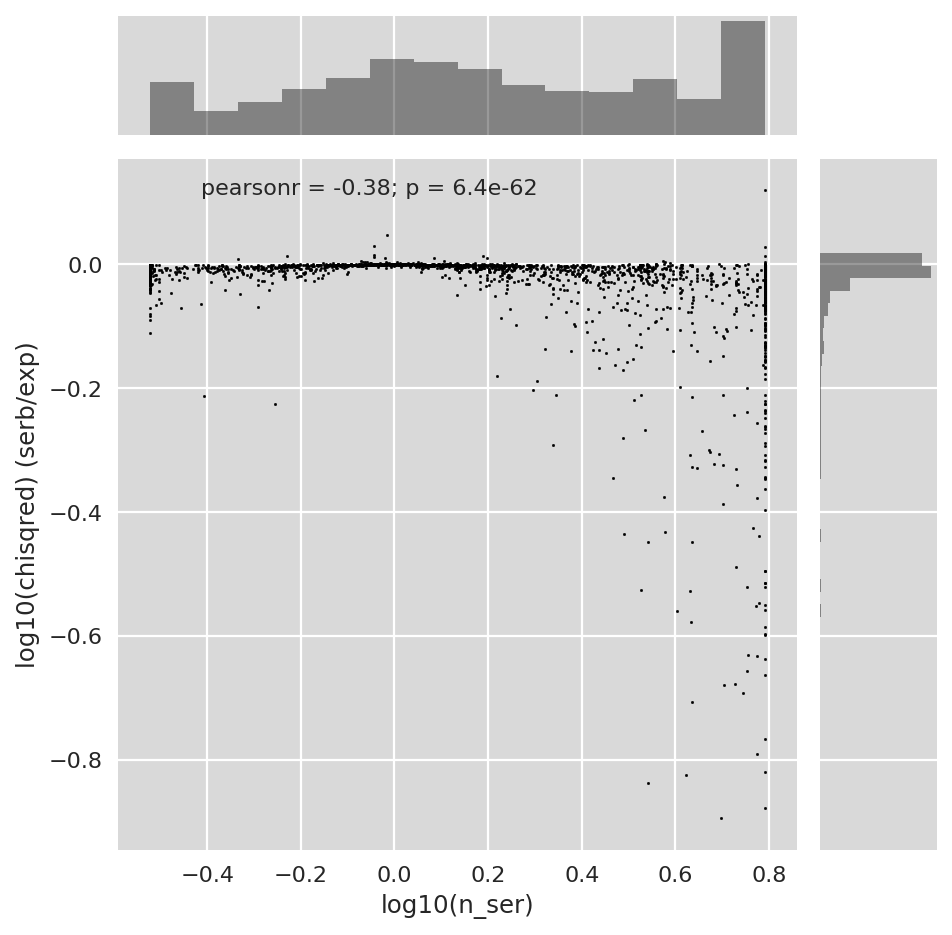

In [11]:
# Now compare only single-component models: Sersic vs best fixed n
modelsfixedn = ["gausspx", "mgexppx", 'mgn2px', "mgdev2px"] 
chisqredcolsfixedn = {
    model: ".".join(["profit", "hst", model, "chisqred", "0"]) 
    for model in modelsfixedn
}
modelbest = tab[list(chisqredcolsfixedn.values())].idxmin(axis=1)
print(modelbest.value_counts())
# I seriously cannot figure out how to slice with modelbest
# Surely there's a better way to do this?
modelchisqmin = tab[list(chisqredcolsfixedn.values())].min(axis=1)
for colxname in ["mgserbpx", 'serb']: 
    labelbest = 'log10(chisqred) ({}/{})'.format(colxname, "best([gauss,exp,n2,dev]px)")
    ratiobest = tab[chisqredcols[colxname]]/modelchisqmin
    # Plots:
    # How much better is Sersic than the best [gauss/exp/dev] vs how good is the 
    # fit and vs Sersic index
    # As above but vs exp only
    colnser = colxname.join(["profit.hst.", ".n"])
    cols = [
        (tab[chisqredcols[colxname]], ratiobest,
         'log10(chisqred) ({})'.format(colxname), labelbest), 
        (tab[colnser], ratiobest, 'log10(n_ser)', labelbest),
        (tab[colnser], tab[chisqredcols[colxname]]/tab[chisqredcols["mgexppx"]],
         'log10(n_ser)', 'log10(chisqred) ({}/exp)'.format(colxname)),
    ]
    for x, y, labelx, labely in cols:
        sns.jointplot(
            x=np.log10(x),
            y=np.log10(y),
            color="k", joint_kws={'marker': '.', 's': 4},
            marginal_kws={'hist_kws': {'log': False}},
        ).set_axis_labels(labelx, labely)